<a href="https://colab.research.google.com/github/jakezweifler/ml_image_projects/blob/main/VAE_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# Check if you're on Google drive or on your own machine.
# Get path to your data.
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    #predir='/content/ME/My Drive/'
    predir='ME/My Drive/Colab Notebooks/ml-large-scale/'
else:
    predir = '/Users/jzweifler/Documents/ml large scale/'


import torch
import numpy as np

# Torch functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pickle
from random import shuffle
import matplotlib.pylab  as plt
import matplotlib.pylab as py

import h5py


# Utility to track progress of a routine.
#from tqdm import tqdm
from tqdm.notebook import trange, tqdm

# Folder with course data
datadir=predir
MNISTdir=predir + 'mnist/'
CIFARdir = predir + 'CIFAR/'
savedir = predir + 'final proj models/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

Mounted at ME
cuda:0


In [ ]:
def timer(start, end):
    hrs, rem = divmod(end-start, 3600)
    mins, secs = divmod(rem, 60)
    print('{:0>2} hours {:0>2} minutes {:05.2f} seconds'.format(int(hrs), int(mins), secs))

In [ ]:
import time
# An object containing the relevant parameters for running the experiment.
class params(object):
    def __init__(self):
        #model parameters
        self.batch_size=1000
        self.step_size=.001
        self.num_epochs=4
        self.dropout=0.

        #layer parameters
        self.input_dim=784
        self.latent_dim=10
        self.hidden_dim=256

        #train/val/test counts
        self.train_perc = 0.8
        self.val_perc = 0.1
        self.test_perc = 0.1

        #model types
        self.minimizer="Adam"
        self.data_set="mnist"
        self.data_dir = MNISTdir
        self.model_name="model"

        self.device=device

pars=params()

In [ ]:
class ImageLoader():

    def __init__(self, params, single_lab = None, extra_data = True):
        self.data_set = params.data_set
        self.batch_size = params.batch_size
        self.extra_data = extra_data
        self.single_num = single_lab

        self.cut1 = params.train_perc
        self.cut2 = params.train_perc + params.val_perc

        self.X_train, self.Y_train, self.X_val, self.Y_val, self.X_test, self.Y_test = self.load_data()

        self.create_batches()
        self.reset_batch_pointer()


    def load_data(self):
        if self.data_set == 'mnist':
            data=np.float64(np.load(MNISTdir + 'MNIST_data.npy'))
            labels=np.int32(np.load(MNISTdir + 'MNIST_labels.npy'))
            data=np.float32(data)/255.
        elif self.data_set == 'cifar':
            with h5py.File(CIFARdir +'cifar10_train.hdf5', "r") as f:
                tr=f[('data')][:].transpose(0,3,1,2)
                tr_lb=f[('labels')][:]
            d1=np.float32(tr)/255.
            l1=tr_lb

            with h5py.File(datadir+'CIFAR/cifar10_test.hdf5', "r") as f:
                te=f[('data')][:].transpose(0,3,1,2)
                te_lb=f[('labels')][:]
            d2=np.float32(te)/255.
            l2=np.int64(te_lb)

            data = np.concatenate((d1, d2), axis=0)
            data = data.reshape(data.shape[0], -1)
            labels = np.concatenate((l1, l2), axis=0)

        else:
            raise NotImplementedError

        if self.single_num is not None:
            data = data[labels == self.single_num]
            labels = labels[labels == self.single_num]

        cut1 = int(self.cut1 * len(data))
        cut2 = int(self.cut2 * len(data))

        train_dat=data[0:cut1]
        train_labels=labels[0:cut1]
        val_dat=data[cut1:cut2]
        val_labels=labels[cut1:cut2]
        test_dat=data[cut2:]
        test_labels=labels[cut2:]

        if self.extra_data:
            print("X_train size:", train_dat.shape)
            print("Y_train size:", train_labels.shape)
            print("X_test size:", test_dat.shape)
            print("Y_test size:", test_labels.shape)

        return train_dat, train_labels, val_dat, val_labels, test_dat, test_labels


    # tensor size = the length of the entire data sequence
    # divide into batch_size sub sequences and stack
    # cut those by seq_length to produce batches of [batch size, seq_length] sized examples
    def create_batches(self):

        self.num_batches = int(self.X_train.shape[0] / self.batch_size)

        if self.num_batches == 0:
            assert False, 'Not enough data. Make batch_size smaller'

        #TODO: randomize X_train here

        self.X_train = self.X_train[:self.num_batches * self.batch_size]  # so we get an even divide
        self.Y_train = self.Y_train[:self.num_batches * self.batch_size]  # so we get an even divide

        self.X_train_batches = np.split(self.X_train, self.num_batches, 0)
        self.Y_train_batches = np.split(self.Y_train, self.num_batches, 0)


        if self.extra_data:
            print("batch tensor size:", self.X_train_batches[0].shape)

        # xdata: L length
        # xdata reshaped: batch_size, (L/batch_size) length following natural indexing
        # np.split: into num batches batches along the width(sentence)

    def next_batch(self):
        x, y = self.X_train_batches[self.pointer], self.Y_train_batches[self.pointer]
        self.pointer += 1
        return x,y

    def reset_batch_pointer(self):
        self.pointer = 0

    def get_data(self):
        return (self.X_train, self.Y_train), (self.X_val, self.Y_val), (self.X_test, self.Y_test)

In [ ]:
#functions for displaying numbers

#just shows the numbers in nums
def display_nums(nums, title = None):
    nrows = int(len(nums)/5); ncols = 5

    plt.figure(figsize=(ncols*2, nrows*2))

    if title is not None:
        plt.suptitle(title, fontsize=16)

    for i in range(len(nums)):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(nums[i].reshape((28,28)), cmap='gray')
        plt.axis('off')
        plt.title(f'{i+1} sample point')

    plt.show()

#showing a single number with some corresponding samples
def display_num_with_samples(num, samples):
    nrows = int(len(samples)/5) + 1; ncols = 5

    plt.figure(figsize=(ncols*2, nrows*2))

    plt.subplot(nrows, ncols, 1)
    plt.imshow(num.reshape((28,28)), cmap='gray')
    plt.axis('off')
    plt.title(f'Original number image')

    for i in range(len(samples)):
        plt.subplot(nrows, ncols, i+6)
        plt.imshow(samples[i].reshape((28,28)), cmap='gray')
        plt.axis('off')
        plt.title(f'sample point {i+1}')

    plt.show()


#just shows the cifar images
def display_cifar(ims, title = None):
    nrows = int(len(ims)/5); ncols = 5
    plt.figure(figsize=(ncols*2, nrows*2))

    ims = ims.reshape(-1, 3, 32, 32)

    if title is not None:
        plt.suptitle(title, fontsize=16)

    for i in range(len(ims)):
        plt.subplot(nrows, ncols, i+1)
        imsT = np.transpose(ims[i], (1, 2, 0))
        plt.imshow(imsT)
        plt.axis('off')
        plt.title(f'{i+1} sample point')

    plt.show()

#showing a single cifar with some corresponding samples
def display_cifar_with_samples(im, samples):
    nrows = int(len(samples)/5) + 1; ncols = 5
    plt.figure(figsize=(ncols*2, nrows*2))

    plt.subplot(nrows, ncols, 1)
    im = im.reshape(3, 32, 32)
    im = np.transpose(im, (1, 2, 0))
    plt.imshow(im)
    plt.axis('off')
    plt.title(f'Original cifar image')

    for i in range(len(samples)):
        plt.subplot(nrows, ncols, i+6)
        imT = samples[i].reshape(3, 32, 32)
        imT = np.transpose(imT, (1, 2, 0))
        plt.imshow(imT)
        plt.axis('off')
        plt.title(f'sample point {i+1}')

    plt.show()

X_train size: (56000, 784)
Y_train size: (56000,)
X_test size: (7000, 784)
Y_test size: (7000,)
batch tensor size: (1000, 784)
[5 0 4 1 9 2 1 3 1 4]


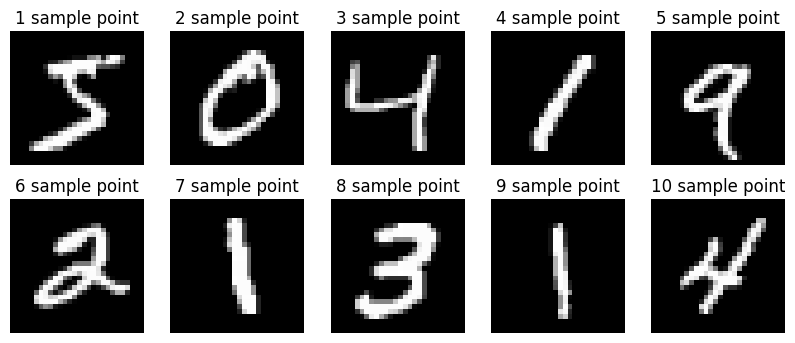

X_train size: (48000, 3072)
Y_train size: (48000,)
X_test size: (6000, 3072)
Y_test size: (6000,)
batch tensor size: (1000, 3072)
[6 9 9 4 1 1 2 7 8 3]


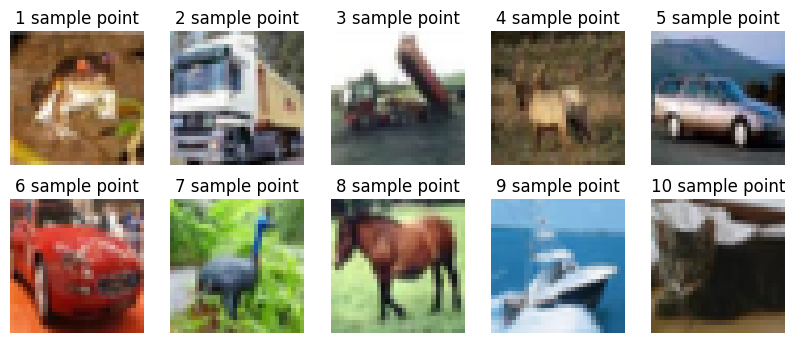

In [ ]:
loader = ImageLoader(pars)

(Xtrain, Ytrain), (Xtest, Ytest), (Xval, Yval) = loader.get_data()

print(Ytrain[:10])

display_nums(Xtrain[:10])


cifarpars=params()
cifarpars.data_set = 'cifar'
cifarpars.input_dim = 3072

cifarloader = ImageLoader(cifarpars)
(cXtrain, cYtrain), (cXtest, cYtest), (cXval, cYval) = cifarloader.get_data()

print(cYtrain[:10])
display_cifar(cXtrain[:10])


#Part A: Write the code that defines the VAE network and trains it.

## These next three cells contain the encoder, decoder, and the combined VAE

In [ ]:
#Encoder cell
class EncoderCell(nn.Module):
    def __init__(self, inp, hid, d):
        super().__init__()
        self.input_dim = inp
        self.hidden_dim = hid
        self.d = d
        #latent space is d dimensional, so there are 2d values here

        self.enc_hidden1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.relu = nn.ReLU()
        self.emb_to_mus = nn.Linear(self.hidden_dim, self.d)
        self.emb_to_logsigs = nn.Linear(self.hidden_dim, self.d)


    def forward(self, x):
        x = self.enc_hidden1(x)
        x = self.relu(x)
        mus = self.emb_to_mus(x)
        logsigs = self.emb_to_logsigs(x)

        return mus, logsigs


In [ ]:
#Decoder cell
class DecoderCell(nn.Module):
    def __init__(self, inp, hid, d):
        super().__init__()
        self.input_dim = inp
        self.hidden_dim = hid
        self.d = d

        self.dec_hidden1 = nn.Linear(self.d, self.hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(self.hidden_dim, self.input_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        z = self.dec_hidden1(z)
        z = self.relu(z)
        z = self.output_layer(z)
        z = self.sigmoid(z)
        z = torch.clamp(z, min = 0.01, max = 0.99)

        return z

In [ ]:
#Putting things together to form the VAE
class VAEnet(nn.Module):
    def __init__(self, params, extra_data = True):
        super().__init__()
        self.input_dim = params.input_dim
        self.hidden_dim = params.hidden_dim
        self.d = params.latent_dim
        self.extra_data = extra_data

        self.enc_cell = EncoderCell(self.input_dim, self.hidden_dim, self.d)
        self.dec_cell = DecoderCell(self.input_dim, self.hidden_dim, self.d)

        # self.init_weights()

        # Setup the optimizer type and send it the parameters of the model
        if params.minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = params.step_size)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = params.step_size)


        #calculating the total number of parameters and printing if extra_data is True
        self.tot_pars=0
        for k,p in self.named_parameters():
            self.tot_pars+=p.numel()

        if self.extra_data:
            print('Total parameters: ',self.tot_pars)


    # not sure if this is necessary, it makes results slightly worse
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)


    #TODO: perhaps split this into two different functions
    def forward(self, x):
        mus, logsigs = self.enc_cell(x) #will be shape (bs, d)
        Z = self.sample_from_distr(mus, logsigs)
        rho_O = self.dec_cell(Z)

        #from experimentation, recon_loss is about 3x kl_loss
        kl_loss = self.KL_div_loss(mus, logsigs)
        recon_loss = self.reconstr_loss(x, rho_O)

        batch_losses = kl_loss + recon_loss
        #getting the average loss over the batches
        loss = batch_losses.mean()
        kl_loss = kl_loss.mean()
        recon_loss = recon_loss.mean()

        return mus, logsigs, rho_O, loss, kl_loss, recon_loss


    #this is the embedding layer that turns (mus, logsigs) into
    def sample_from_distr(self, mus, logsigs):
        epsilon = torch.randn_like(mus)
        Z = mus + torch.exp(logsigs) * epsilon
        return Z


    #computes KL( N(mu, sigma^2) || N(0, I) )
    def KL_div_loss(self, mus, logsigs):
        sigs_sqr = torch.square(torch.exp(logsigs))
        mus_sqr = torch.square(mus)
        batch_losses = -0.5 * (1 + 2 * logsigs - mus_sqr - sigs_sqr)
        batch_losses = torch.sum(batch_losses, dim=1)
        return batch_losses

    #computes -log P(X | Z) via assumed bernoulli distr
    #note: this is essentially just F.binary_cross_entropy
    def reconstr_loss(self, X, rho_O):
        batch_losses = - (X * torch.log(rho_O) + (1 - X) * torch.log(1 - rho_O))
        batch_losses = torch.sum(batch_losses, dim=1)
        return batch_losses


    # Compute classification and loss and then do a gradient step on the loss.
    def run_grad(self,x):
        mus, logsigs, rho_O, loss, kl_loss, recon_loss = self.forward(x)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return mus, logsigs, rho_O, loss, kl_loss, recon_loss


    def get_encoder(self):
        return self.enc_cell

    def get_decoder(self):
        return self.dec_cell


# Code that runs a single epoch

In [ ]:
def run_epoch(net,epoch,train,params):

    train_size=train.shape[0]
    ii=np.array(np.arange(0,train_size,1))
    np.random.shuffle(ii)
    tr=train[ii]

    train_loss=0
    kl_loss = 0
    recon_loss = 0

    # for j in trange(0,n,params.batch_size):
    for j in range(0,train_size,params.batch_size):

        # Transfer the batch from cpu to gpu (or do nothing if you're on a cpu)
        data=torch.torch.from_numpy(tr[j:j+pars.batch_size]).to(params.device)

        # Implement Adam step on batch
        _, _, _, loss, kl_losses, recon_losses = net.run_grad(data)

        train_loss += loss.item()
        kl_loss += kl_losses.item()
        recon_loss += recon_losses.item()

    num_batches = train_size / params.batch_size
    train_loss /= num_batches
    kl_loss /= num_batches
    recon_loss /= num_batches

    print('Training set epoch {}: Avg. loss: {:.4f}'.format(epoch, train_loss))

    return train_loss, kl_loss, recon_loss



In [ ]:
def get_val_loss(net,val,pars,set_name = 'Validation'):
    net.eval()
    # with torch.no_grad():

    val_size=val.shape[0]
    test_loss = 0
    for j in np.arange(0,val_size,pars.batch_size):

        # Transfer the batch from cpu to gpu (or do nothing if you're on a cpu)
        data=torch.from_numpy(val[j:j+pars.batch_size]).to(device)

        #getting the loss from the data
        _, _, _, loss, _, _ = net(data)

        test_loss += loss.item()


    num_batches = val_size / pars.batch_size
    test_loss /= num_batches


    print('{} set: Avg. loss: {:.4f}\n'.format(set_name, test_loss))

    return test_loss




In [ ]:
def train_net(pars, single_digit = None):
    # Initialize the network
    net = VAEnet(pars).to(pars.device)

    #getting the data
    loader = ImageLoader(pars, single_lab=single_digit)
    (Xtr, Ytr), (Xte, Yte), (Xvl, Yvl) = loader.get_data()

    train_losses = []
    kl_losses = []
    recon_losses = []
    val_losses = []

    start_time = time.time()


    for i in range(pars.num_epochs):
        # Run one epoch of training
        train_loss, kl_loss, recon_loss = run_epoch(net,i, Xtr, pars)
        train_losses.append(train_loss)
        kl_losses.append(kl_loss)
        recon_losses.append(recon_loss)

        # Test on validation set.
        val_loss = get_val_loss(net,Xvl,pars)
        val_losses.append(val_loss)



    # Save the model to a file
    torch.save(net.state_dict(), os.path.join(savedir, f'saved_{pars.model_name}_model.pt'))
    end_time = time.time()

    timer(start_time, end_time)

    return net, train_losses, kl_losses, recon_losses, val_losses

In [ ]:
pars.num_epochs = 20
pars.latent_dim=20
pars.hidden_dim=256
pars.model_name = "model1"

trained_net, train_losses, kl_losses, recon_losses, val_losses = train_net(pars)

Total parameters:  418104
X_train size: (56000, 784)
Y_train size: (56000,)
X_test size: (7000, 784)
Y_test size: (7000,)
batch tensor size: (1000, 784)
Training set epoch 0: Avg. loss: 280.0348
Validation set: Avg. loss: 213.0820

Training set epoch 1: Avg. loss: 202.0328
Validation set: Avg. loss: 187.4785

Training set epoch 2: Avg. loss: 174.8043
Validation set: Avg. loss: 165.5530

Training set epoch 3: Avg. loss: 159.8094
Validation set: Avg. loss: 153.9664

Training set epoch 4: Avg. loss: 149.9181
Validation set: Avg. loss: 146.0825

Training set epoch 5: Avg. loss: 142.8757
Validation set: Avg. loss: 140.1551

Training set epoch 6: Avg. loss: 137.6412
Validation set: Avg. loss: 135.6540

Training set epoch 7: Avg. loss: 133.6098
Validation set: Avg. loss: 132.1569

Training set epoch 8: Avg. loss: 130.6524
Validation set: Avg. loss: 129.7734

Training set epoch 9: Avg. loss: 128.4614
Validation set: Avg. loss: 127.7514

Training set epoch 10: Avg. loss: 126.6590
Validation set

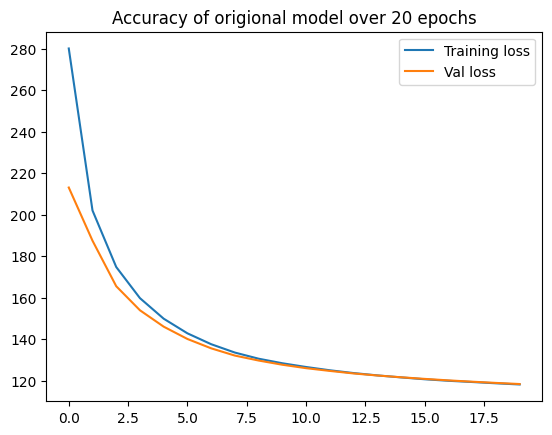

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Training loss", "Val loss"])
plt.title("Accuracy of origional model over 20 epochs")
plt.show()


The model works! Note that the loss has two parts: the reconstruction loss plus the KL loss, which measure the distance the mus and sigs are away from a normal distribution. Thus, I wanted to see what the contributions were of each of these types of loss to the overall loss.

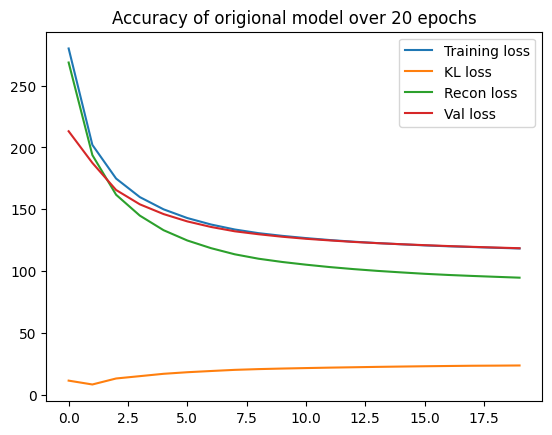

In [ ]:
plt.plot(train_losses)
plt.plot(kl_losses)
plt.plot(recon_losses)
plt.plot(val_losses)
plt.legend(["Training loss", "KL loss", "Recon loss", "Val loss"])
plt.title("Accuracy of origional model over 20 epochs")
plt.show()

### Analysis:

Wow! The KL loss is much less than the recon loss. This suggests that the model is trying harder to manage the recon loss. If we want better images, we could try to change the coefficent, weighting the KL loss to be more. I tried this, but it did not help too much.


# Part B:
Once the model is trained, provide some reconstructed images. You take a test image run it through the encoder to get $Emb(X) = [\mu(X), log \sigma(X)]$, sample $Z = \mu(X) + \sigma(X)ϵ$, with  $ \epsilon \sim N (0, I) \in \mathbb{R}^d$ then compute $\rho(O)$ reshape it into an image and display it along side the orginal test image X.

In [ ]:
def get_sample_images(real_num, net):
    enc1 = net.cpu().get_encoder()
    dec1 = net.cpu().get_decoder()

    real_num = torch.torch.from_numpy(real_num)
    mus, logsigs = enc1(real_num)

    new_samples = []

    for i in range(5):
        #new_sample = dec1(trained_net.cpu().sample_from_distr(mus, sigmas))

        #these three lines are essentially the same as sample_from_distr
        epsilon = torch.randn_like(mus)
        Z = mus + torch.exp(logsigs) * epsilon
        new_sample = dec1(Z)

        new_samples.append(new_sample.detach().numpy())

    return new_samples


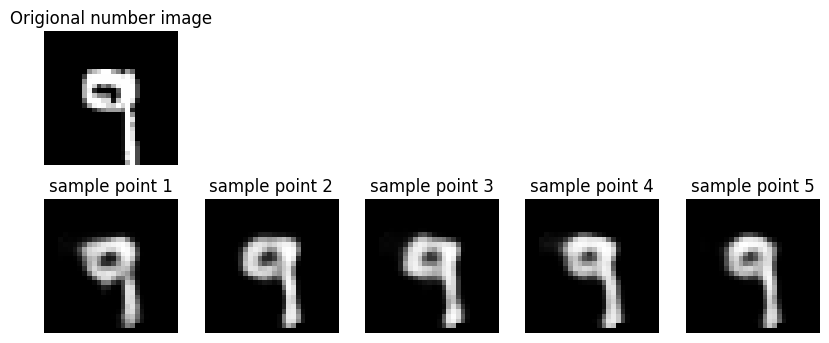

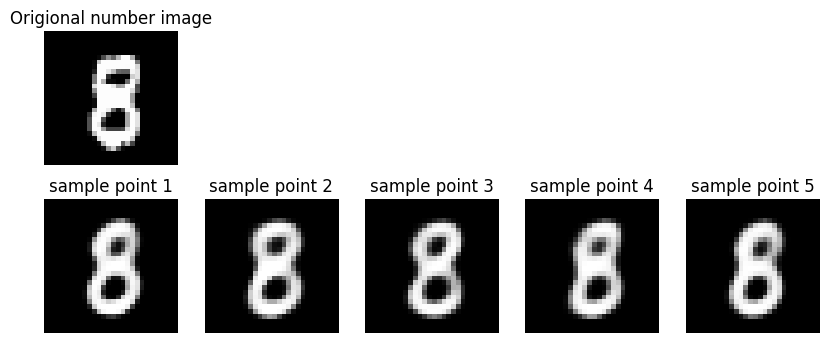

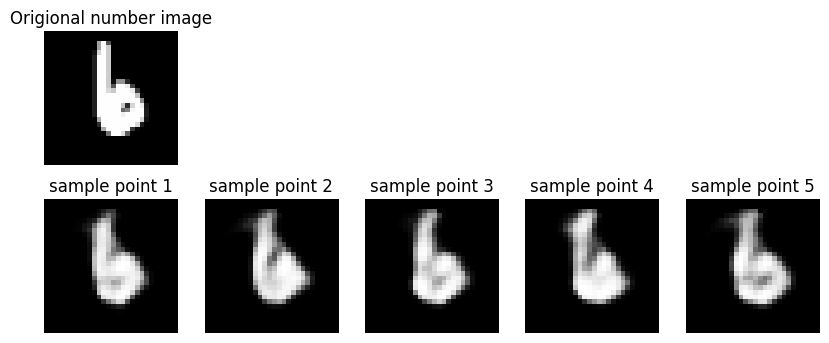

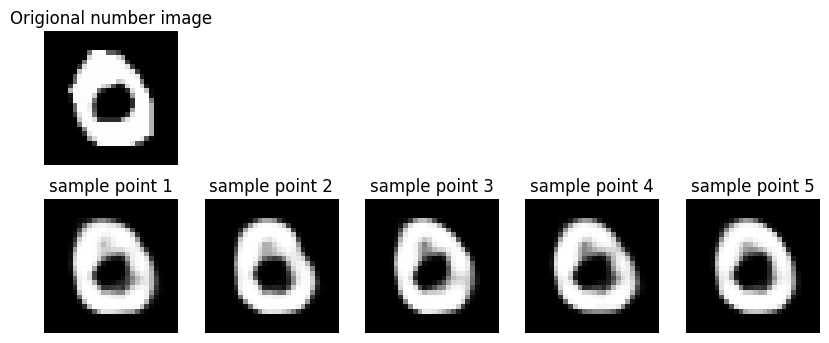

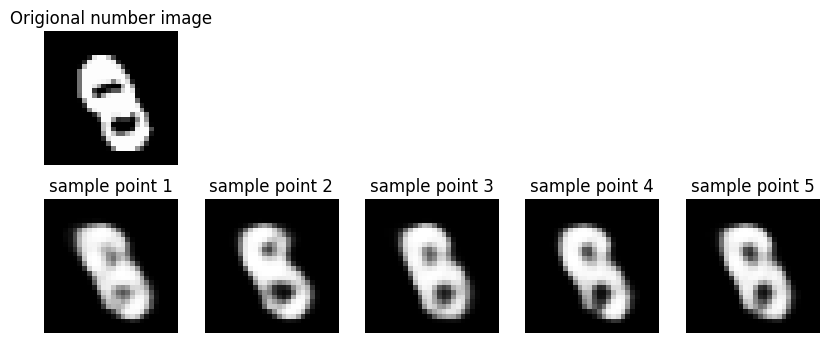

In [ ]:
for i in range(5):
    real_num = Xtest[i]
    samples = get_sample_images(real_num, trained_net)

    display_num_with_samples(real_num, samples)

### Analysis:
As you can see above, the sample points are quite close to the origional number! We can definitely distinguish what the origional number is if only given the sample point. Still, the sample points are a bit blurrier and worse quality than the origional number, so the model is not perfect.

##Part C:
Now sample a standard normal $Z\sim N(0,I) \in \mathbb{R}^d$, compute $\rho(O)(Z)$ and display the sample. Do this 100 times to get a nice view of samples of the generative model.

In [ ]:
def gen_random_samples(net, num_samples):
    dec1 = net.cpu().get_decoder()
    dim = net.d

    #sampling the Z's from N(0,I)
    Z = torch.randn(num_samples, dim)

    new_samples = dec1(Z).detach().numpy()

    return new_samples


one hundred sampled numbers from the decoder:


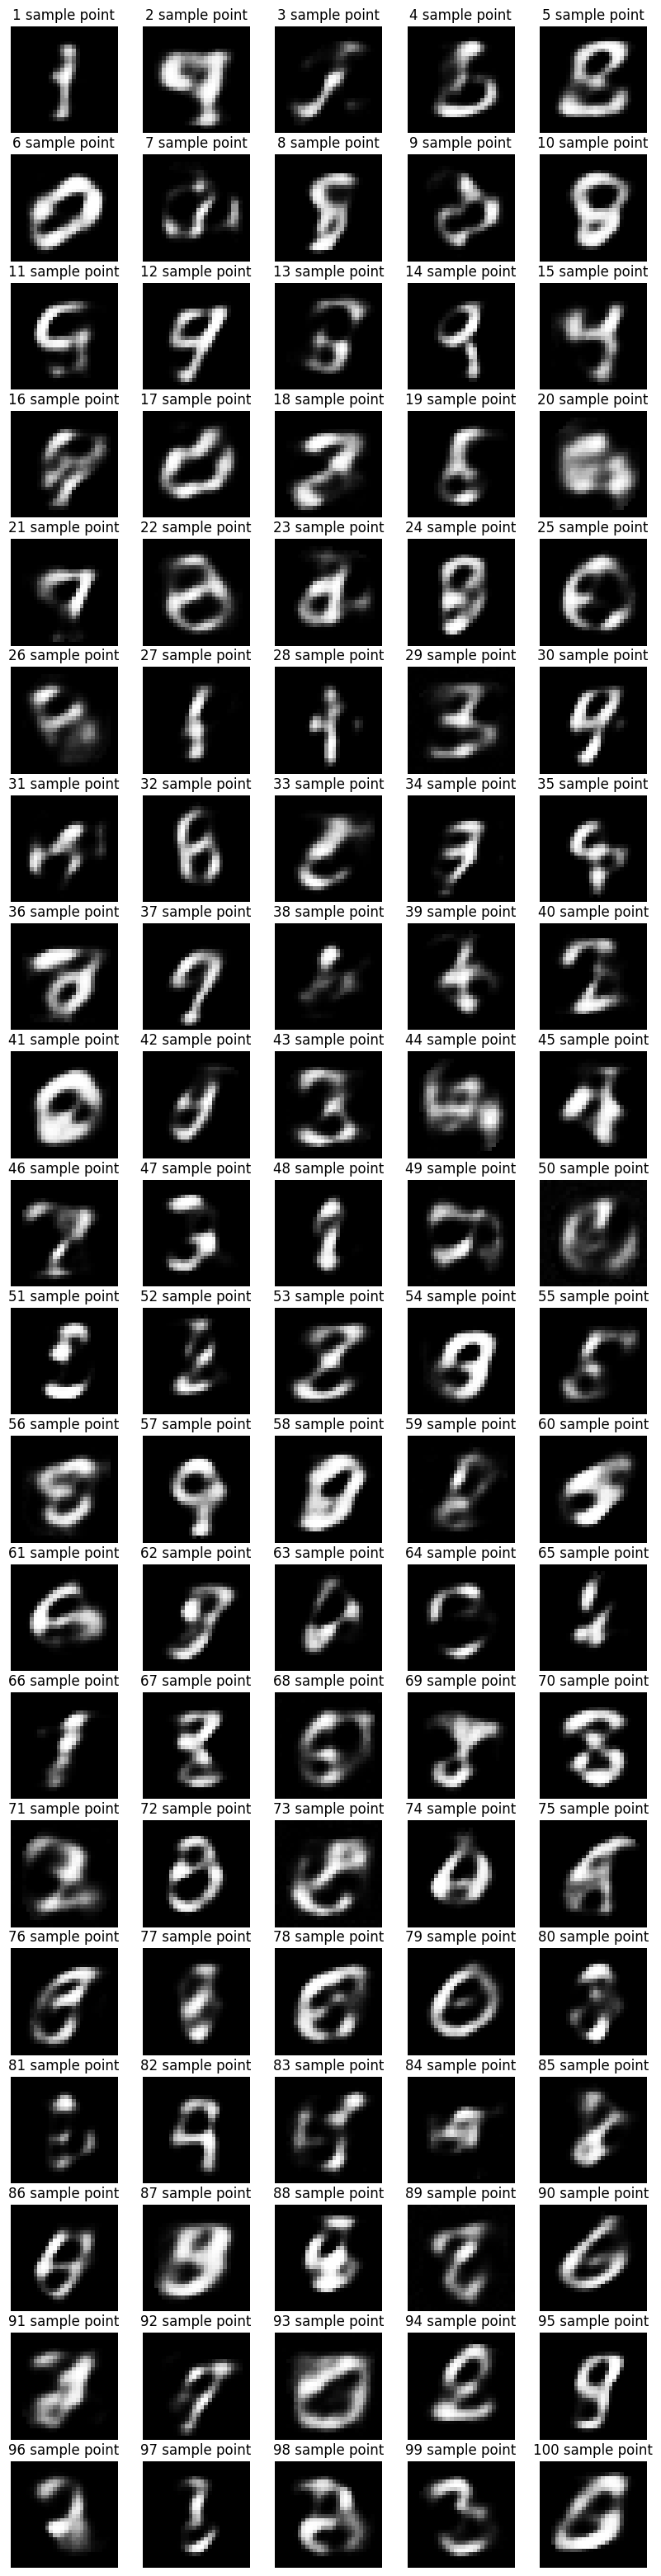

In [ ]:
one_hundred_samples = gen_random_samples(trained_net, 100)

print("one hundred sampled numbers from the decoder:")
display_nums(one_hundred_samples)

### Analysis:

Now, the numbers are clearly worse. However, this is expected considering we sample from a completely random distribution. It is actually qutie miraculous that we can generate anything at all given we start with complete randomness. Many of the numbers above are identifiable as an actual number. Nonetheless, most of the images look malformed and computer generated. So while it is cool that we have generated anything at all resembling written numbers, there is still much work to be done to create numbers that look very handwritten.

Lets try things again for a larger model and see if the images look better

In [ ]:
pars.num_epochs = 20
pars.latent_dim= 100
pars.hidden_dim= 5000
pars.model_name = "model_boosted"

trained_net, train_losses, _, _, val_losses = train_net(pars)

Total parameters:  9350984
X_train size: (56000, 784)
Y_train size: (56000,)
X_test size: (7000, 784)
Y_test size: (7000,)
batch tensor size: (1000, 784)
Training set epoch 0: Avg. loss: 212.5094
Validation set: Avg. loss: 181.1810

Training set epoch 1: Avg. loss: 166.8852
Validation set: Avg. loss: 157.3953

Training set epoch 2: Avg. loss: 151.2207
Validation set: Avg. loss: 144.8881

Training set epoch 3: Avg. loss: 139.9568
Validation set: Avg. loss: 135.7066

Training set epoch 4: Avg. loss: 132.2701
Validation set: Avg. loss: 129.7110

Training set epoch 5: Avg. loss: 127.1195
Validation set: Avg. loss: 125.9143

Training set epoch 6: Avg. loss: 123.6082
Validation set: Avg. loss: 122.5512

Training set epoch 7: Avg. loss: 121.0887
Validation set: Avg. loss: 120.4896

Training set epoch 8: Avg. loss: 119.2739
Validation set: Avg. loss: 119.1004

Training set epoch 9: Avg. loss: 117.9135
Validation set: Avg. loss: 117.8913

Training set epoch 10: Avg. loss: 116.8417
Validation se

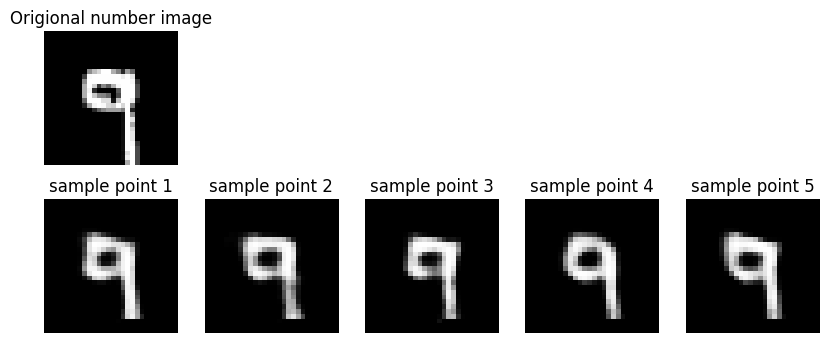

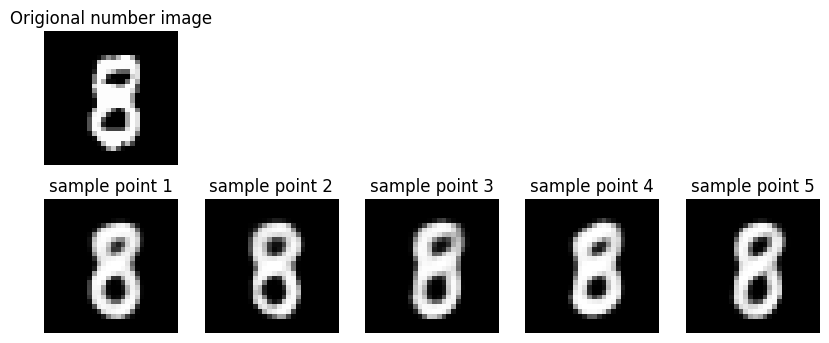

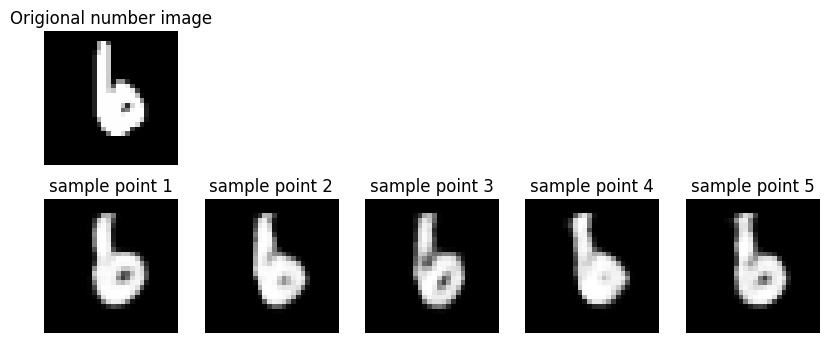

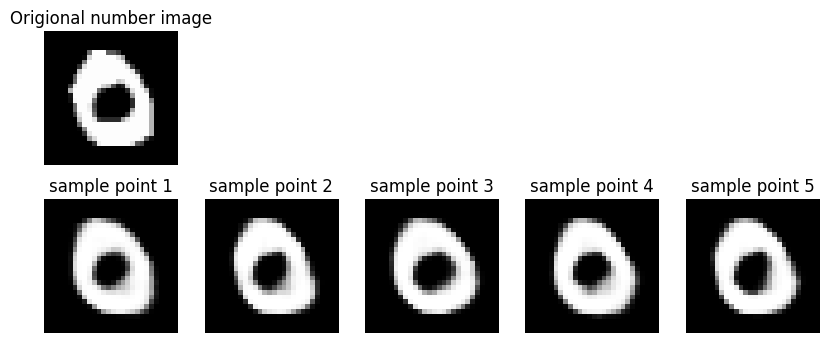

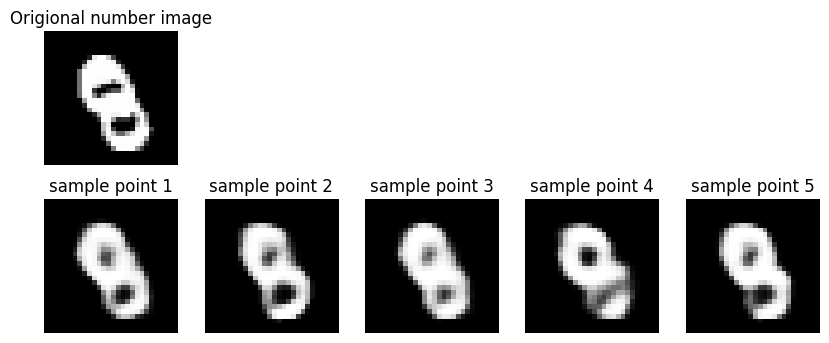

In [ ]:
for i in range(5):
    real_num = Xtest[i]
    samples = get_sample_images(real_num, trained_net)

    display_num_with_samples(real_num, samples)

one hundred sampled numbers from the decoder:


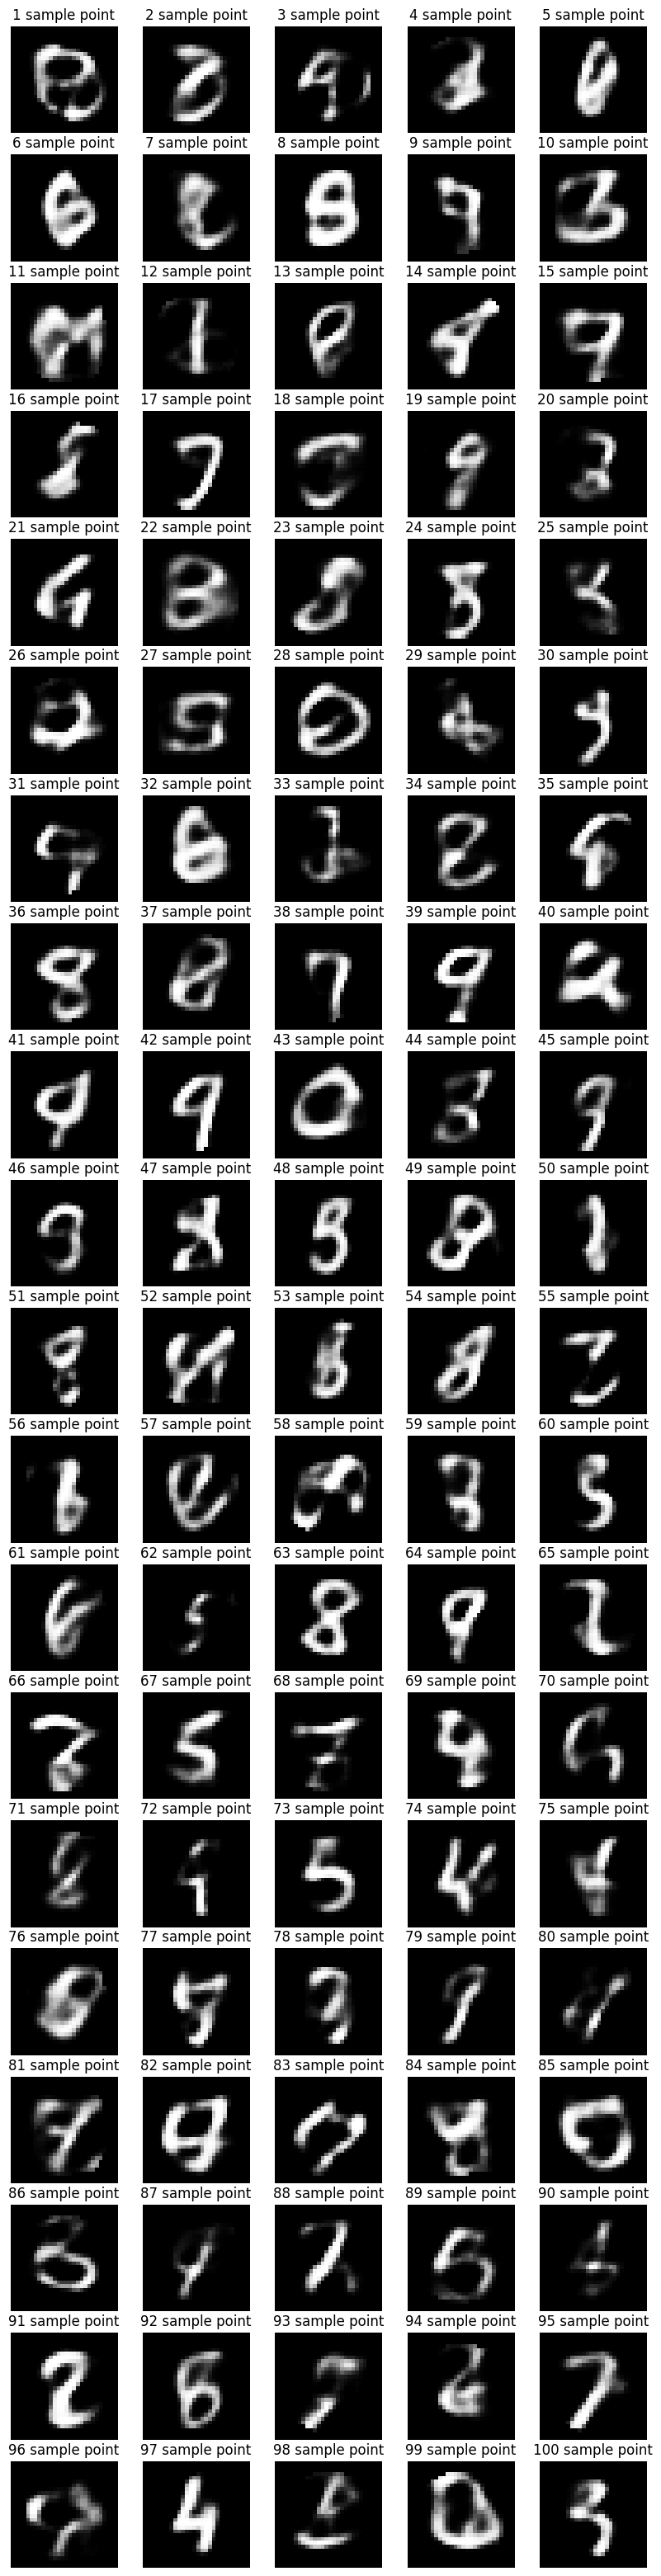

In [ ]:
one_hundred_samples = gen_random_samples(trained_net, 100)

print("one hundred sampled numbers from the decoder:")
display_nums(one_hundred_samples)

### Analysis:

The images generated from a real number like in part b definitely look less fuzzy. Also, the 100 random images indeed look a bit better, but are still pretty malformed.

## Part D:

Try these experiments for different values of the embedding layer d = 10, 20, 40, and for different dimensions of the hidden layer h = 256, 512, 1024. Compute the FID score for each model using 2000 samples generated from the trained decoder and the full training set to estimate $\mu_X, \mu_Y, \Sigma_X, \Sigma_Y$.

For each model record the number of parameters, the final loss on the validation set and the FID score. How correlated are the loss and the FID score? Save a few of your favorite models in terms of the quality of the samples and the reconstructions.

In [ ]:
#here, I use the spectral decomposition to get the sqrt of a symmetric matrix
def get_sqrt_posdef(A, tol = 1e-6):
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(A)

    #if any eigenvalues are slightly negative, make them 0
    if len(eigenvalues[eigenvalues < - tol]) > 0:
        raise ValueError("negative eigenvalue error")

    eigenvalues[eigenvalues < 0] = 0

    #take sqrt of the eigenvalues
    eigenvalues = np.sqrt(eigenvalues)
    Lambda = np.diag(eigenvalues)

    #putting everything back together to get A_sqrt
    A_sqrt = eigenvectors @ Lambda @ eigenvectors.T

    return A_sqrt

def compute_FID_score(X, Y):
    #getting the mus and sigs
    mu_X = np.mean(X, axis=0)
    Sigma_X = np.cov(X, rowvar=False) #this is just X^TX/(sample_size - 1)

    mu_Y = np.mean(Y, axis=0)
    Sigma_Y = np.cov(Y, rowvar=False)

    #computing |mu_X - mu_Y|^2
    mu_diff = np.dot(mu_X - mu_Y, mu_X - mu_Y)

    Sigma_X_sqrt = get_sqrt_posdef(Sigma_X)

    #computing tr(S_X + S_Y - 2(...)^1/2)
    sig_diff = np.trace(Sigma_X + Sigma_Y - 2 * get_sqrt_posdef(Sigma_X_sqrt @ Sigma_Y @ Sigma_X_sqrt))

    return mu_diff + sig_diff



In [ ]:
model_FID = {}
model_param = {}
model_val_loss = {}

for d in [10,20,40,80, 160]:
    for h in [256, 512, 1024, 2048, 4096, 10000]:

        pars.num_epochs = 20
        pars.latent_dim= d
        pars.hidden_dim= h
        pars.model_name = f"model {d,h}"

        trained_net, train_losses, _, _, val_losses = train_net(pars)

        X = Xtest
        Y = gen_random_samples(trained_net, 2000)

        FID_score = compute_FID_score(X, Y)
        param_count = trained_net.tot_pars
        last_val_loss = val_losses[-1]

        model_FID[(d, h)] = FID_score
        model_param[(d, h)] = param_count
        model_val_loss[(d, h)] = last_val_loss




Total parameters:  410404
X_train size: (56000, 784)
Y_train size: (56000,)
X_test size: (7000, 784)
Y_test size: (7000,)
batch tensor size: (1000, 784)
Training set epoch 0: Avg. loss: 278.6190
Validation set: Avg. loss: 213.9482

Training set epoch 1: Avg. loss: 200.4179
Validation set: Avg. loss: 186.2364

Training set epoch 2: Avg. loss: 173.8650
Validation set: Avg. loss: 162.5367

Training set epoch 3: Avg. loss: 157.6262
Validation set: Avg. loss: 152.9187

Training set epoch 4: Avg. loss: 150.0241
Validation set: Avg. loss: 146.1357

Training set epoch 5: Avg. loss: 143.8921
Validation set: Avg. loss: 141.0374

Training set epoch 6: Avg. loss: 139.3319
Validation set: Avg. loss: 137.1715

Training set epoch 7: Avg. loss: 135.9885
Validation set: Avg. loss: 134.4582

Training set epoch 8: Avg. loss: 133.7498
Validation set: Avg. loss: 132.6491

Training set epoch 9: Avg. loss: 131.9462
Validation set: Avg. loss: 131.0209

Training set epoch 10: Avg. loss: 130.5050
Validation set

model with dim = 10 and hidden = 256:
 FID score = 12.4285, val loss = 123.7458, num params = 410404

model with dim = 10 and hidden = 512:
 FID score = 10.9981, val loss = 119.8887, num params = 820004

model with dim = 10 and hidden = 1024:
 FID score = 11.2940, val loss = 117.3507, num params = 1639204

model with dim = 10 and hidden = 2048:
 FID score = 11.0991, val loss = 115.2845, num params = 3277604

model with dim = 10 and hidden = 4096:
 FID score = 11.0215, val loss = 114.2145, num params = 6554404

model with dim = 10 and hidden = 10000:
 FID score = 11.8731, val loss = 122.0405, num params = 16000804

model with dim = 20 and hidden = 256:
 FID score = 9.0780, val loss = 119.1774, num params = 418104

model with dim = 20 and hidden = 512:
 FID score = 8.2211, val loss = 114.9379, num params = 835384

model with dim = 20 and hidden = 1024:
 FID score = 7.3789, val loss = 112.6887, num params = 1669944

model with dim = 20 and hidden = 2048:
 FID score = 8.0739, val loss = 11

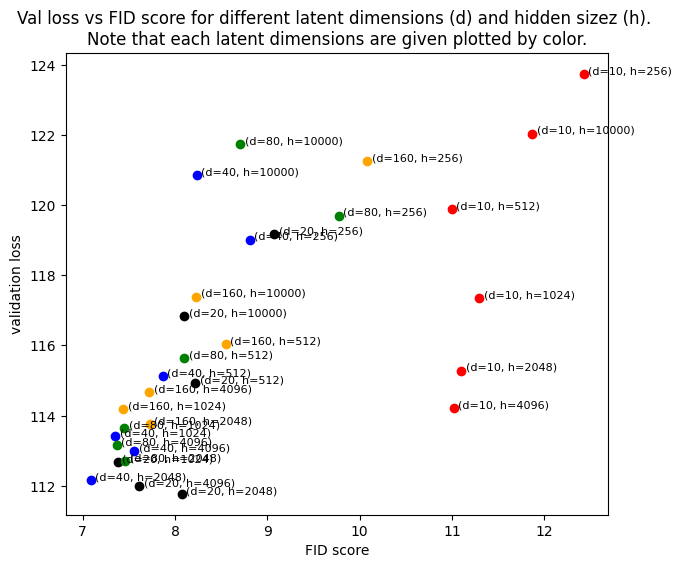

In [ ]:
import matplotlib.pyplot as py

py.figure(figsize=(7,6))

color_dic = {10 : 'red', 20 : 'black', 40 : 'blue', 80 : 'green', 160 : 'orange'}

for d in [10,20,40,80, 160]:
    for h in [256, 512, 1024, 2048, 4096, 10000]:
        fid = model_FID[(d,h)]
        param = model_param[(d,h)]
        val_loss = model_val_loss[(d,h)]

        py.scatter(fid, val_loss, color=color_dic[d])
        py.annotate(f"(d={d}, h={h})", (fid + .05, val_loss), fontsize=8)



        print('model with dim = {} and hidden = {}:\n FID score = {:.4f}, val loss = {:.4f}, num params = {}\n'.format(
              d,h,fid,val_loss, param))




py.title("Val loss vs FID score for different latent dimensions (d) and hidden sizez (h). \nNote that each latent dimensions are given plotted by color.")
py.xlabel('FID score')
py.ylabel('validation loss')
py.show()

### Analysis:

As you can see from this graph, d = 10 isnt very good. But neither is d = 160! There is a general trend where loss is correlated to FID score, but it is not exact. When d = 10, the FID score is about the same for all the models, but increasing the hidden layer decreases the loss by a significant amount. Also, having a large hidden layer of 10000 made the results worse — probably vanishing gradient. It seems the best model overall has d = 40 and h = 2048, so even h = 4096 becomes too much for the hidden size.

In [ ]:
pars.latent_dim= 40
pars.hidden_dim= 2048
favorite_model_1 = VAEnet(pars)
favorite_model_1.load_state_dict(torch.load(os.path.join(savedir, f'saved_model (40, 2048)_model.pt')))

Total parameters:  3461984


<All keys matched successfully>

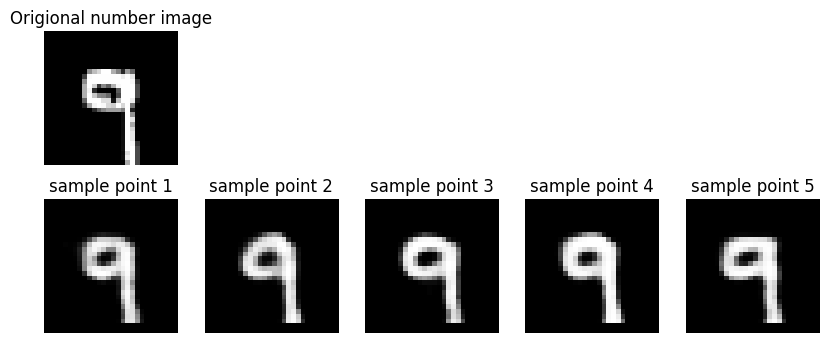

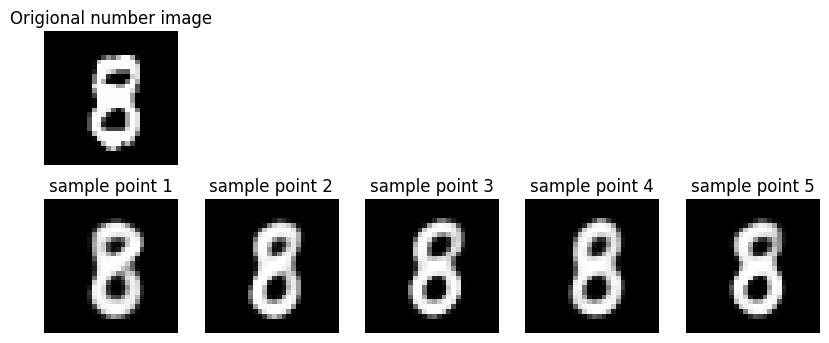

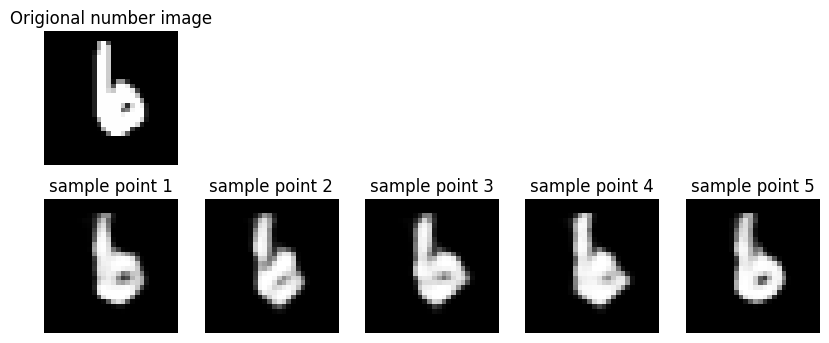

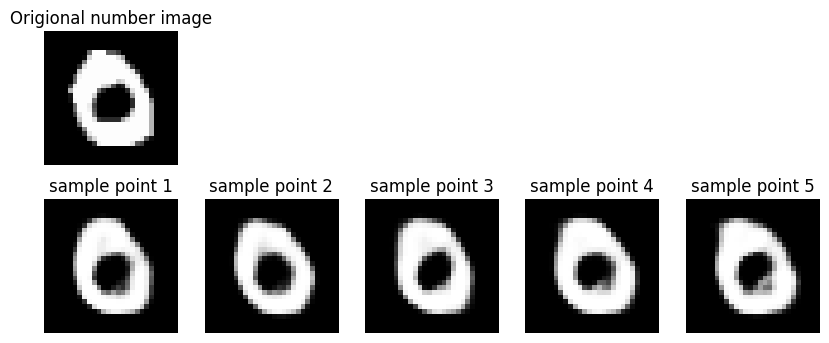

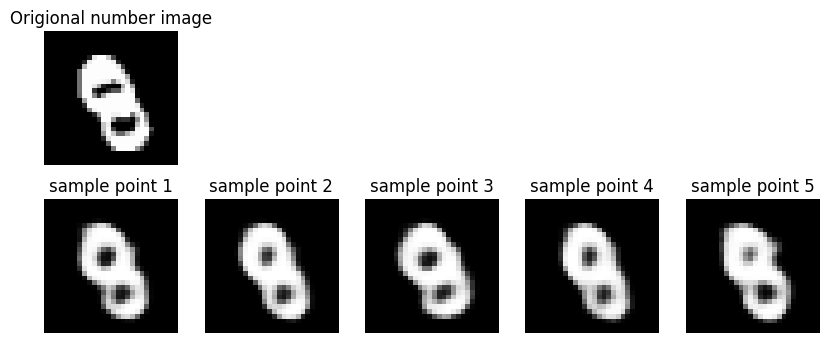

In [ ]:
for i in range(5):
    real_num = Xtest[i]
    samples = get_sample_images(real_num, favorite_model_1)

    display_num_with_samples(real_num, samples)

one hundred sampled numbers from the decoder:


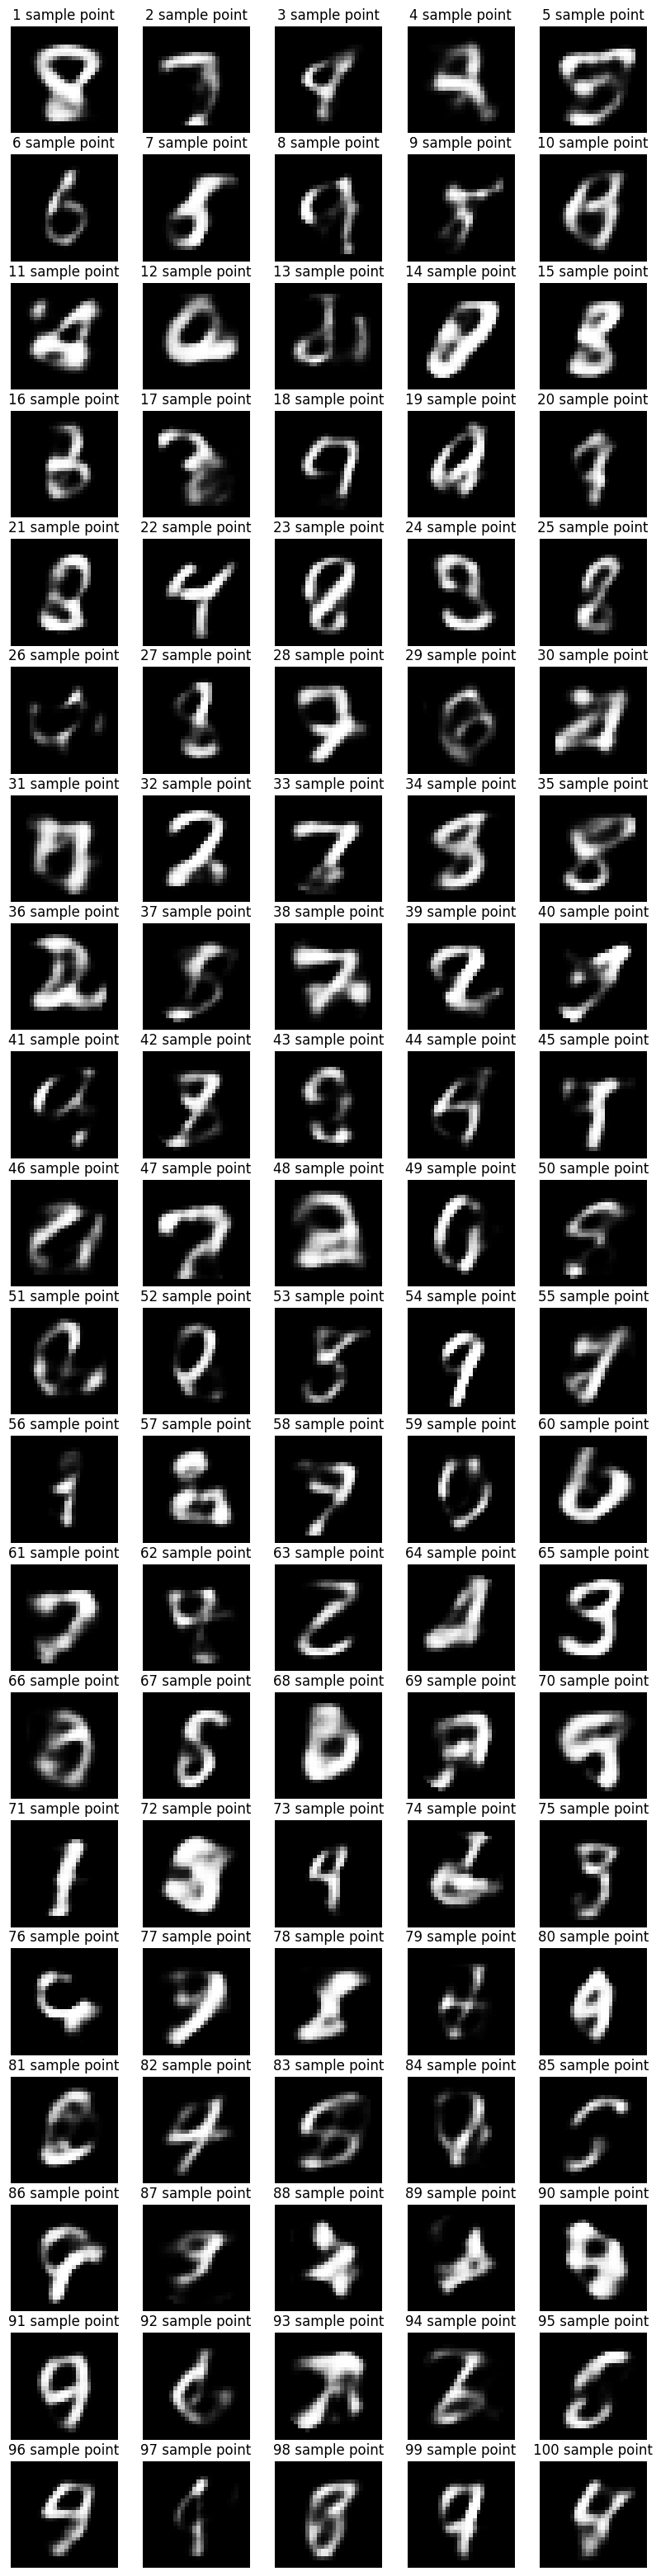

In [ ]:
one_hundred_samples = gen_random_samples(favorite_model_1, 100)

print("one hundred sampled numbers from the decoder:")
display_nums(one_hundred_samples)

### Analysis:

This is the model with the best FID score. It does a bit better than some of the other models.

## Part F:

Write code for this computation. Remember that in the algorithm we used
the negative of the lower bound in (1), so you want to print out $-Q_k$. Run this computation on your validation set for your favorite saved models, for $k = 10, 100, 1000$. Does $−Q _k$ decrease as a function of $k$? Does it seem to converge? If it does it is probably a good approximation of $L(\theta) = \sum^n_{i=1} \log p(X_i; \theta)$, where
θ is the parameters of the decoder.

In [ ]:
def gaussian_log_density(z, mu, logsig):
    normalization_constant = -0.5 * (np.log(2 * np.pi) + 2*logsig)
    square_term = -0.5 * ((z - mu) / torch.exp(logsig)) ** 2
    log_density = normalization_constant + square_term
    log_density = log_density.sum(dim=1)
    return log_density


#this is just reconstr_loss from the VAE
def BCE_loss(X, rho_O):
    batch_losses = (X * torch.log(rho_O) + (1 - X) * torch.log(1 - rho_O))
    batch_losses = batch_losses.sum(dim=1)
    return batch_losses


def Q_k(net, data, k):
    with torch.no_grad():

        enc1 = net.cpu().get_encoder()
        dec1 = net.cpu().get_decoder()

        mus, logsigs = enc1(data)

        #This is where we will store the sums meant to be logsumexp'ed
        log_weights = torch.zeros(len(data), k)

        for i in range(k):
            epsilon = torch.randn_like(mus)
            Z = mus + torch.exp(logsigs) * epsilon
            rho_O = dec1(Z)

            #Log density of the sample under the variational distribution, i.e., just q(z | x)
            log_qzx = gaussian_log_density(Z, mus, logsigs)

            #Log density of the sample under the prior, i.e, just p(z)
            log_pz = gaussian_log_density(Z, torch.zeros_like(mus), torch.zeros_like(logsigs))

            #this is just the p(x | z) term in the numerator
            log_px = BCE_loss(data, rho_O)

            # Weight for the sample
            log_weights[:, i] = log_pz + log_px - log_qzx

            # Log sum of weights across the k's
            log_weight_sum = torch.logsumexp(log_weights, dim=1)
            log_weight_sum = log_weight_sum - np.log(k)



        Q_sum = log_weight_sum.mean()

    return Q_sum


In [ ]:
for k in [1,10,50,100]:
    negQ_kval = -Q_k(favorite_model_1, torch.torch.from_numpy(Xval), k = k).item()

    print(f"negQ_kval for k = {k}: {negQ_kval}")


negQ_kval for k = 1: 112.14105224609375
negQ_kval for k = 10: 109.3951187133789
negQ_kval for k = 50: 108.59815216064453
negQ_kval for k = 100: 108.35731506347656


## Analysis:

So it seems that the -Q_k value does keep decreasing (i.e., the Q_k values are increasing) and it levels off around 108. So it seems to converge and is probably a good estimator for L(theta). One thing to note is that the Q_k values are definitely smaller than the loss I calculated in the VAE code. However, note that when k = 1, we get a loss very similar to the loss from the VAE code! Thus, the code for Q_k must be correct.

## Part G:

Classification with the embeddings For a your model of choice in terms
of size of hidden layer, extract the embedding [μ(x), log σ(x)] for each example, which yields a 2s dimensional vector for s = 10, 40, 80, 160. Try classifying the MNIST digits with a linear classifier using the embeddings as input features. You can use SVC from sklearn.svm scikit-learn as your default linear classifier. Compare this to training the classifier directly on the raw data. How do your results change with the dimension s and how do they change with the number of labeled training data used to train the classifier. Remember: the VAE is trained with unlabeled data, which is much easier to acquire.

Thankfully, I saved all the models!

In [ ]:
from sklearn.svm import LinearSVC


train_data = torch.torch.from_numpy(Xtrain)
test_data = torch.torch.from_numpy(Xtest)

def get_accuracy_from_embed(dim, num_labs = 56000, h = 2048):
    pars.latent_dim=dim
    pars.hidden_dim=h
    mnodel = VAEnet(pars, extra_data = False)
    mnodel.load_state_dict(torch.load(os.path.join(savedir, f'saved_model ({dim}, {h})_model.pt')))

    enc1 = mnodel.cpu().get_encoder()
    dec1 = mnodel.cpu().get_decoder()

    mus, logsigs = enc1(train_data[:num_labs])
    mus_test, logsigs_test = enc1(test_data)

    combined_features = torch.cat((mus, logsigs), dim=1)
    combined_features = combined_features.detach().numpy()

    combined_features_test = torch.cat((mus_test, logsigs_test), dim=1)
    combined_features_test = combined_features_test.detach().numpy()

    #now we train and test a linear model
    lin_model = LinearSVC(max_iter=20000)
    lin_model.fit(combined_features, Ytrain[:num_labs])
    preds = lin_model.predict(combined_features_test)

    correct = (Ytest == preds).sum()
    acc = correct / len(Ytest)

    return acc


def get_accuracy_directly(num_labs = 56000):
    X_train = Xtrain[:num_labs]
    Y_train = Ytrain[:num_labs]

    lin_model = LinearSVC(max_iter=20000)

    lin_model.fit(X_train, Y_train)
    preds = lin_model.predict(Xtest)
    correct = (Ytest == preds).sum().item()
    acc = correct / len(Ytest)

    return acc




In [ ]:
for num_labs in [100, 1000, 10000, 56000]:

    print(f"Trials for {num_labs} label numbers:")
    acc_lin = get_accuracy_directly(num_labs)
    print(f"Accuracy for linear model on direct data: {acc_lin}")
    for s in [10, 40, 80, 160]:
        acc_emb = get_accuracy_from_embed(s, num_labs)
        print(f"Embedding accuracy for s = {s}: {acc_emb}")

    print("")


Trials for 100 label numbers:
Accuracy for linear model on direct data: 0.7091428571428572
Embedding accuracy for s = 10: 0.7274285714285714
Embedding accuracy for s = 40: 0.6767142857142857
Embedding accuracy for s = 80: 0.68
Embedding accuracy for s = 160: 0.676

Trials for 1000 label numbers:
Accuracy for linear model on direct data: 0.8628571428571429
Embedding accuracy for s = 10: 0.8824285714285715
Embedding accuracy for s = 40: 0.8898571428571429
Embedding accuracy for s = 80: 0.8874285714285715
Embedding accuracy for s = 160: 0.8954285714285715

Trials for 10000 label numbers:
Accuracy for linear model on direct data: 0.9044285714285715
Embedding accuracy for s = 10: 0.8985714285714286
Embedding accuracy for s = 40: 0.9322857142857143
Embedding accuracy for s = 80: 0.9402857142857143
Embedding accuracy for s = 160: 0.952

Trials for 56000 label numbers:
Accuracy for linear model on direct data: 0.9234285714285714
Embedding accuracy for s = 10: 0.9031428571428571
Embedding accur

### Analysis:

So see that there is indeed a difference when we compare s and label numbers. When there are fewer labels, i.e., the training set is small, the linear classifier works better than the embedding classifier. Moreover, the embedding classifier starts to does worse as s increases. However, as we train on more samples, the embedding classifier starts to do better, and moreover, does increasingly better as we increase s. When we train on 10,000 samlles, the highest s of 160 still gives large returns in accuracy, performing 1% better than s = 80. In total, s=160 for 10,000 samples gives 95% accuracy which is QUITE high compared to all the other classifiers we have seen.

Note that this means we can run the VAE on unlabeled data to get embeddings in order to do this. Thus, we can rely on smaller labeled sets with the help of unlabeled data (although we technically still need the labels to train the linear classifier, we can probably get these labels a more efficient way using the VAE embeddigns).

In summary, for a fixed label count, increasing s makes the model do better, but eventually there are marginal and even negative returns. However,is the label count is increased, the effect of increasing s is boosted, and we no longer see these marginal returns, unless we make s very large.

## Part H:

Classification with generative models. In HW4 you classified MNIST digits
using generative models based on training a mixture model for each class. Now
you’ll try to do the same with a VAE trained for each class. Once you create
your 10 models, you want to test using Qk(X) estimate of the likelihood for
the test example, for each class. Try this for k = 10, 100. Do you get different error rates? Try this generative approach for classification of MNIST, choosing
the best model (from among some of the models you’ve already explored in
previous sections) on the validation set, and then retraining the VAE’s using
the combined training and validation set.

Note that I altered the dataloader code to allow for single digits. Note that I still use d = 40 and h = 2048, which I found was best above.

In [ ]:
ten_models = []
ten_losses = []
Q10_vals = []
Q100_vals = []


#here are the params for my favorite model
pars.latent_dim= 40
pars.hidden_dim= 2048

for i in range(10):
    trained_net_num, train_losses_num, _, _, val_losses_num = train_net(pars, single_digit = i)
    ten_models.append(trained_net_num)

    Xtest_nums = Xtest[Ytest == i]

    negQ10_val = -Q_k(trained_net_num, torch.torch.from_numpy(Xtest_nums), k = 10).item()
    negQ100_val = -Q_k(trained_net_num, torch.torch.from_numpy(Xtest_nums), k = 100).item()

    Q10_vals.append(negQ10_val)
    Q100_vals.append(negQ100_val)



Total parameters:  3461984
X_train size: (5522, 784)
Y_train size: (5522,)
X_test size: (691, 784)
Y_test size: (691,)
batch tensor size: (1000, 784)
Training set epoch 0: Avg. loss: 375.0950
Validation set: Avg. loss: 336.0312

Training set epoch 1: Avg. loss: 224.4353
Validation set: Avg. loss: 306.5312

Training set epoch 2: Avg. loss: 211.8802
Validation set: Avg. loss: 296.7963

Training set epoch 3: Avg. loss: 208.1498
Validation set: Avg. loss: 292.2046

00 hours 00 minutes 03.20 seconds
Total parameters:  3461984
X_train size: (6301, 784)
Y_train size: (6301,)
X_test size: (788, 784)
Y_test size: (788,)
batch tensor size: (1000, 784)
Training set epoch 0: Avg. loss: 296.0460
Validation set: Avg. loss: 172.3460

Training set epoch 1: Avg. loss: 122.1430
Validation set: Avg. loss: 131.7869

Training set epoch 2: Avg. loss: 106.2605
Validation set: Avg. loss: 126.9090

Training set epoch 3: Avg. loss: 103.5332
Validation set: Avg. loss: 124.0928

00 hours 00 minutes 00.31 seconds


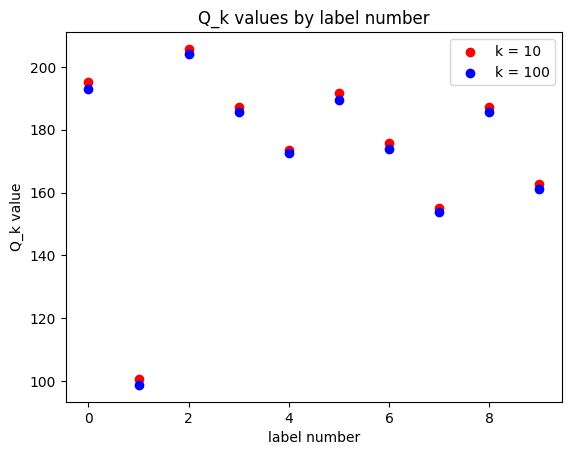

In [ ]:

nums = list(range(10))
py.scatter(nums, Q10_vals, color='red', label='k = 10')
py.scatter(nums, Q100_vals, color='blue', label='k = 100')


py.title("Q_k values by label number")
py.xlabel('label number')
py.ylabel('Q_k value')
py.legend()
py.show()

## Analysis:

We can see using the loss that indeed, the VAE works much better on some numbers than others. In particular, the VAE does quite well on 1's and 7's, but bad on 2's and 8's. As expected, when $k$ is larger, the $Q_k$ value is larger as well.

20 generated one's:


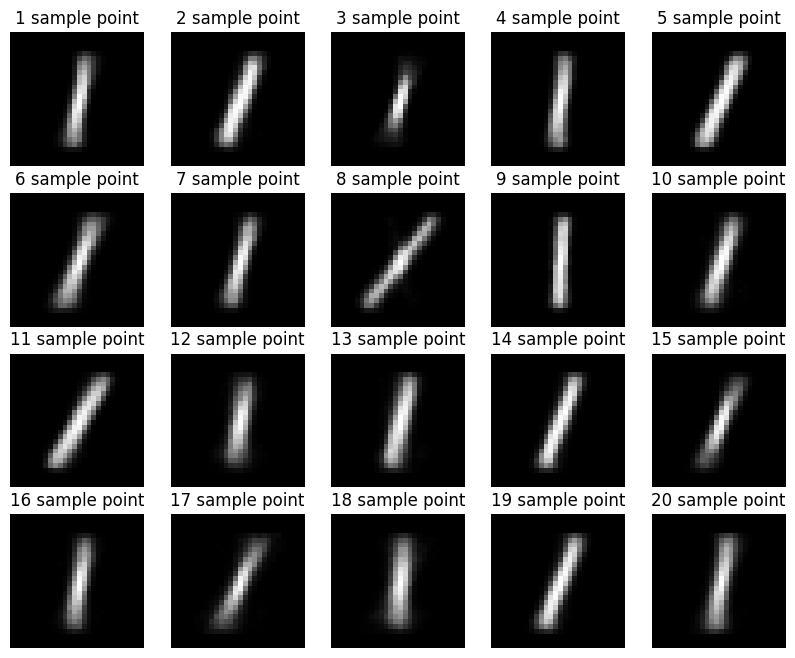

In [ ]:
one_num_samples = gen_random_samples(ten_models[1], 20)

print("20 generated one's:")
display_nums(one_num_samples)


## Analysis:

These look quite good! Especially considering they were generated completely from random.


20 generated eights's:


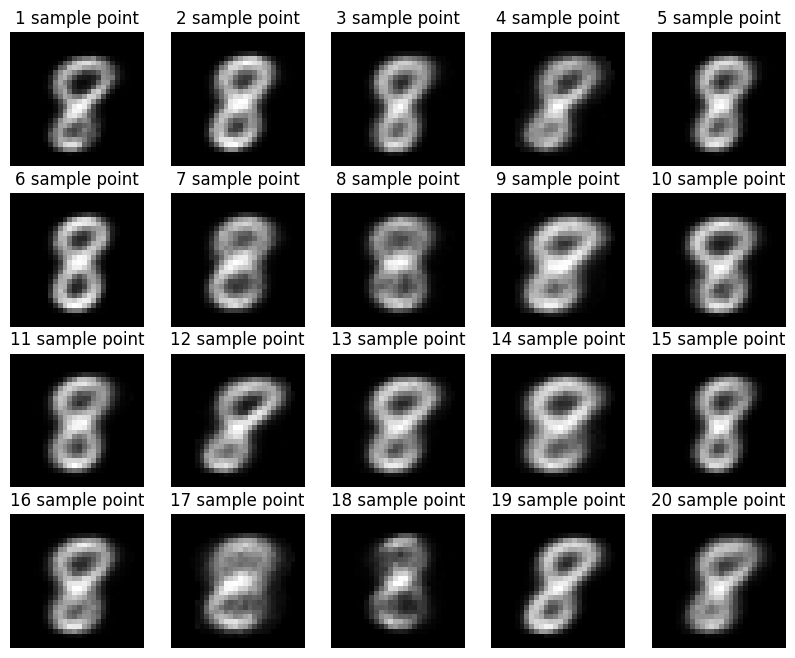

In [ ]:
eight_num_samples = gen_random_samples(ten_models[8], 20)

print("20 generated eights's:")
display_nums(eight_num_samples)

## Analysis:

These are good too, although much more fuzzy than the 1's.

Now lets try to classify! First, lets retrain the model on train and dev:

In [ ]:
ten_models = []
ten_losses = []
Q10_vals = []
Q100_vals = []


#here are the params for my favorite model
pars.latent_dim= 40
pars.hidden_dim= 2048
pars.train_perc = 0.9 #here is where we include 'dev' into train
pars.val_perc = 0.05
pars.test_perc = 0.05

for i in range(10):
    trained_net_num, train_losses_num, _, _, val_losses_num = train_net(pars, single_digit = i)
    ten_models.append(trained_net_num)

    Xtest_nums = Xtest[Ytest == i]

    negQ10_val = -Q_k(trained_net_num, torch.torch.from_numpy(Xtest_nums), k = 10).item()
    negQ100_val = -Q_k(trained_net_num, torch.torch.from_numpy(Xtest_nums), k = 100).item()

    Q10_vals.append(negQ10_val)
    Q100_vals.append(negQ100_val)



Total parameters:  3461984
X_train size: (6212, 784)
Y_train size: (6212,)
X_test size: (346, 784)
Y_test size: (346,)
batch tensor size: (1000, 784)
Training set epoch 0: Avg. loss: 359.6110
Validation set: Avg. loss: 659.3129

Training set epoch 1: Avg. loss: 219.6158
Validation set: Avg. loss: 614.3006

Training set epoch 2: Avg. loss: 209.6898
Validation set: Avg. loss: 604.8539

Training set epoch 3: Avg. loss: 206.5787
Validation set: Avg. loss: 592.0004

00 hours 00 minutes 00.32 seconds
Total parameters:  3461984
X_train size: (7089, 784)
Y_train size: (7089,)
X_test size: (394, 784)
Y_test size: (394,)
batch tensor size: (1000, 784)
Training set epoch 0: Avg. loss: 275.9352
Validation set: Avg. loss: 323.5518

Training set epoch 1: Avg. loss: 115.1307
Validation set: Avg. loss: 264.3011

Training set epoch 2: Avg. loss: 104.9892
Validation set: Avg. loss: 258.0023

Training set epoch 3: Avg. loss: 101.1994
Validation set: Avg. loss: 239.1981

00 hours 00 minutes 00.34 seconds


In [ ]:
def Q_k_no_mean(net, data, k):
    with torch.no_grad():

        enc1 = net.cpu().get_encoder()
        dec1 = net.cpu().get_decoder()

        mus, logsigs = enc1(data)

        #This is where we will store the sums meant to be logsumexp'ed
        log_weights = torch.zeros(len(data), k)

        for i in range(k):
            epsilon = torch.randn_like(mus)
            Z = mus + torch.exp(logsigs) * epsilon
            rho_O = dec1(Z)

            #Log density of the sample under the variational distribution, i.e., just q(z | x)
            log_qzx = gaussian_log_density(Z, mus, logsigs)

            #Log density of the sample under the prior, i.e, just p(z)
            log_pz = gaussian_log_density(Z, torch.zeros_like(mus), torch.zeros_like(logsigs))

            #this is just the p(x | z) term in the numerator
            log_px = BCE_loss(data, rho_O)

            # Weight for the sample
            log_weights[:, i] = log_pz + log_px - log_qzx

            # Log sum of weights across samples
            log_weight_sum = torch.logsumexp(log_weights, dim=1)
            log_weight_sum = log_weight_sum - np.log(k)


        # Q_sum = log_weight_sum.mean()

    return log_weight_sum


In [ ]:
test_Q_vals = []

for i in range(10):
    Q_vals = []
    negQ10_val = Q_k_no_mean(ten_models[i], torch.torch.from_numpy(Xtest), k = 10).numpy()

    test_Q_vals.append(negQ10_val)

test_Q_vals = np.stack(test_Q_vals)
print(test_Q_vals.shape)

test_Q_vals = test_Q_vals.T

(10, 7000)


In [ ]:

print(test_Q_vals.shape)

preds = np.argmax(test_Q_vals, axis=1)

correct = (Ytest == preds).sum().item()
acc = correct / len(Ytest)

print(acc)

(7000, 10)
0.8654285714285714


## Analysis:

So we get 96% accuracy, which is very high! Hooray!

In [ ]:
cifarpars.num_epochs = 40
cifarpars.latent_dim=50
cifarpars.hidden_dim=2048
cifarpars.model_name = "cifar-model1"


trained_net, train_losses, kl_losses, recon_losses, val_losses = train_net(cifarpars)

Total parameters:  12897380
X_train size: (48000, 3072)
Y_train size: (48000,)
X_test size: (6000, 3072)
Y_test size: (6000,)
batch tensor size: (1000, 3072)
Training set epoch 0: Avg. loss: 2059.7185
Validation set: Avg. loss: 1978.6707

Training set epoch 1: Avg. loss: 1959.8877
Validation set: Avg. loss: 1938.6438

Training set epoch 2: Avg. loss: 1923.3547
Validation set: Avg. loss: 1908.2858

Training set epoch 3: Avg. loss: 1903.2291
Validation set: Avg. loss: 1896.4318

Training set epoch 4: Avg. loss: 1894.6415
Validation set: Avg. loss: 1892.2381

Training set epoch 5: Avg. loss: 1886.6570
Validation set: Avg. loss: 1884.3792

Training set epoch 6: Avg. loss: 1880.0833
Validation set: Avg. loss: 1877.2243

Training set epoch 7: Avg. loss: 1872.5199
Validation set: Avg. loss: 1870.1835

Training set epoch 8: Avg. loss: 1867.9180
Validation set: Avg. loss: 1865.7458

Training set epoch 9: Avg. loss: 1865.1365
Validation set: Avg. loss: 1862.4961

Training set epoch 10: Avg. loss

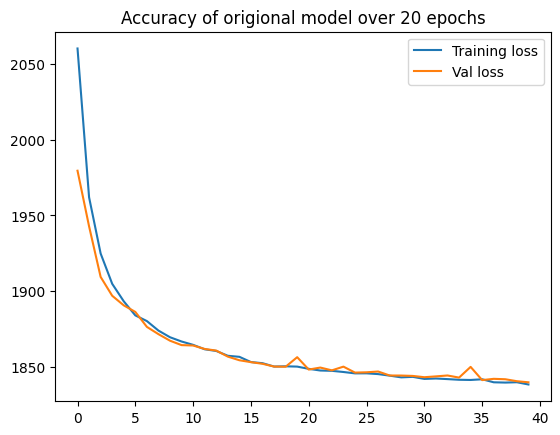

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Training loss", "Val loss"])
plt.title("Accuracy of origional model over 20 epochs")
plt.show()

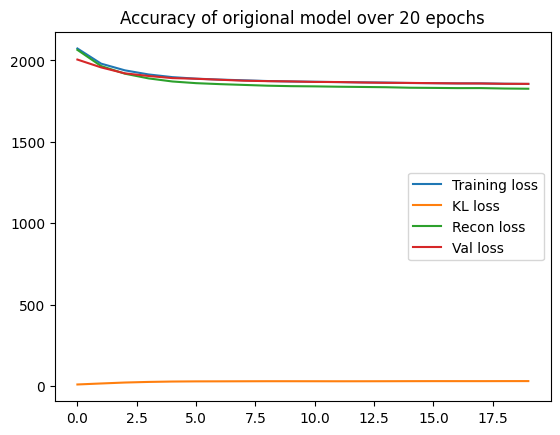

In [ ]:
plt.plot(train_losses)
plt.plot(kl_losses)
plt.plot(recon_losses)
plt.plot(val_losses)
plt.legend(["Training loss", "KL loss", "Recon loss", "Val loss"])
plt.title("Accuracy of origional model over 20 epochs")
plt.show()

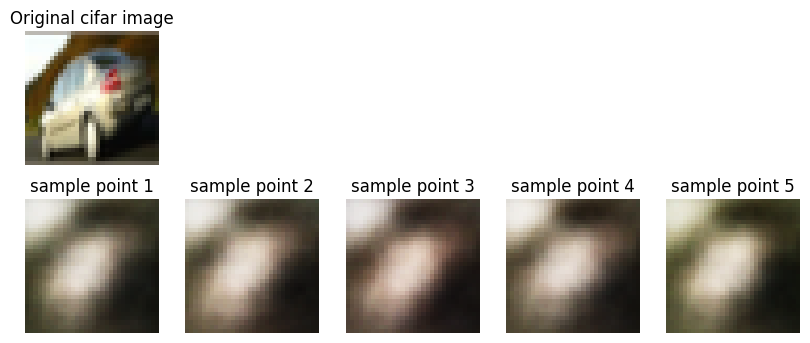

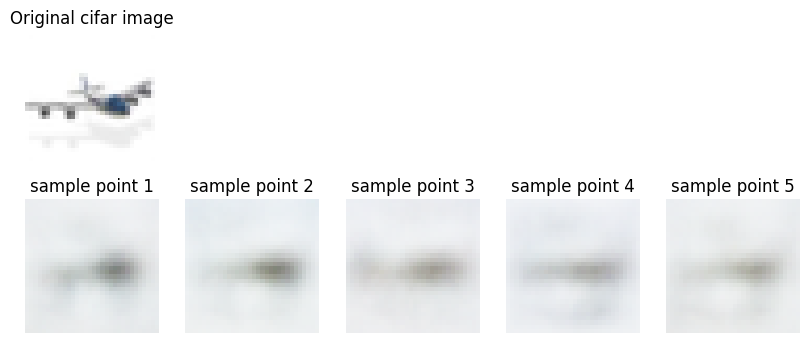

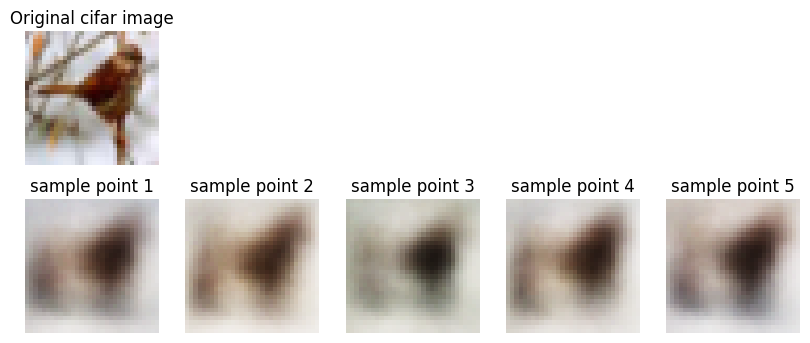

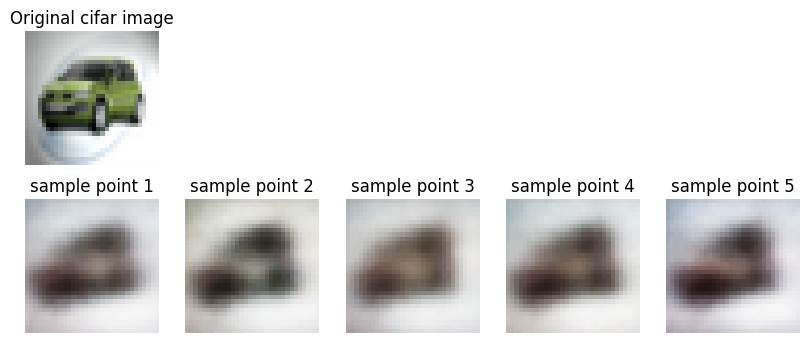

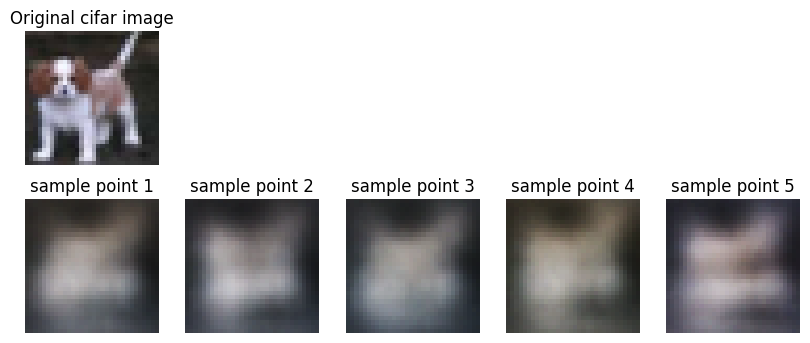

In [ ]:
for i in range(5):
    real_im = cXtest[i]
    samples = get_sample_images(real_im, trained_net)

    display_cifar_with_samples(real_im, samples)



one hundred sampled cifars from the decoder:


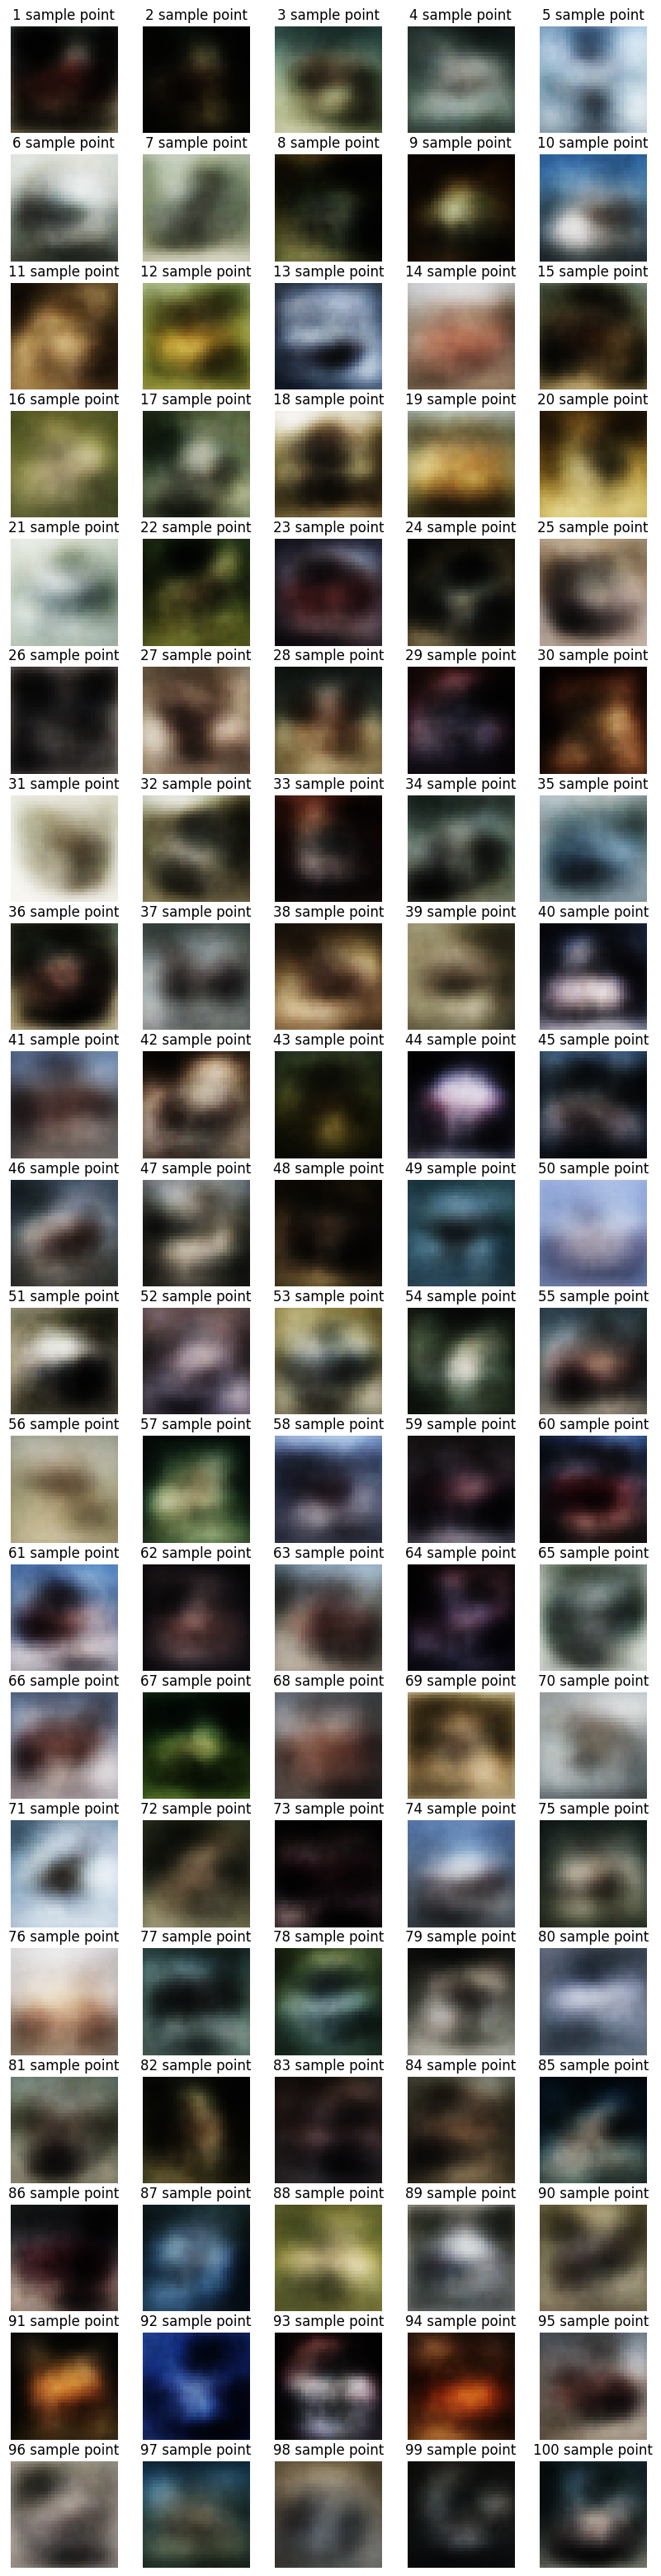

In [ ]:
one_hundred_samples = gen_random_samples(trained_net, 100)

print("one hundred sampled cifars from the decoder:")
display_cifar(one_hundred_samples)

In [ ]:
model_FID = {}
model_param = {}
model_val_loss = {}

for d in [10,20,40,80]:
    for h in [256, 512, 1024, 2048]:

        cifarpars.num_epochs = 50
        cifarpars.latent_dim= d
        cifarpars.hidden_dim= h
        cifarpars.model_name = f"cifar model {d,h}"

        trained_net, train_losses, _, _, val_losses = train_net(cifarpars)

        X = cXtest
        Y = gen_random_samples(trained_net, 2000)

        FID_score = compute_FID_score(X, Y)
        param_count = trained_net.tot_pars
        last_val_loss = val_losses[-1]

        model_FID[(d, h)] = FID_score
        model_param[(d, h)] = param_count
        model_val_loss[(d, h)] = last_val_loss




Total parameters:  1584148
X_train size: (48000, 3072)
Y_train size: (48000,)
X_test size: (6000, 3072)
Y_test size: (6000,)
batch tensor size: (1000, 3072)
Training set epoch 0: Avg. loss: 2061.6212
Validation set: Avg. loss: 1995.3090

Training set epoch 1: Avg. loss: 1967.6508
Validation set: Avg. loss: 1942.9160

Training set epoch 2: Avg. loss: 1926.8750
Validation set: Avg. loss: 1910.5318

Training set epoch 3: Avg. loss: 1898.9762
Validation set: Avg. loss: 1888.3272

Training set epoch 4: Avg. loss: 1885.2248
Validation set: Avg. loss: 1880.5550

Training set epoch 5: Avg. loss: 1878.5946
Validation set: Avg. loss: 1876.8418

Training set epoch 6: Avg. loss: 1875.6843
Validation set: Avg. loss: 1874.1526

Training set epoch 7: Avg. loss: 1876.5996
Validation set: Avg. loss: 1873.5476

Training set epoch 8: Avg. loss: 1872.5645
Validation set: Avg. loss: 1872.2666

Training set epoch 9: Avg. loss: 1871.5943
Validation set: Avg. loss: 1872.1763

Training set epoch 10: Avg. loss:

model with dim = 10 and hidden = 256:
 FID score = 215.2153, val loss = 1864.8995, num params = 1584148

model with dim = 10 and hidden = 512:
 FID score = 185.6657, val loss = 1864.2547, num params = 3165204

model with dim = 10 and hidden = 1024:
 FID score = 234.0496, val loss = 1861.6755, num params = 6327316

model with dim = 10 and hidden = 2048:
 FID score = 198.2709, val loss = 1862.4960, num params = 12651540

model with dim = 20 and hidden = 256:
 FID score = 216.1150, val loss = 1847.0947, num params = 1591848

model with dim = 20 and hidden = 512:
 FID score = 147.2095, val loss = 1843.2580, num params = 3180584

model with dim = 20 and hidden = 1024:
 FID score = 182.7841, val loss = 1840.7489, num params = 6358056

model with dim = 20 and hidden = 2048:
 FID score = 165.9553, val loss = 1840.1586, num params = 12713000

model with dim = 40 and hidden = 256:
 FID score = 191.7412, val loss = 1847.2346, num params = 1607248

model with dim = 40 and hidden = 512:
 FID score 

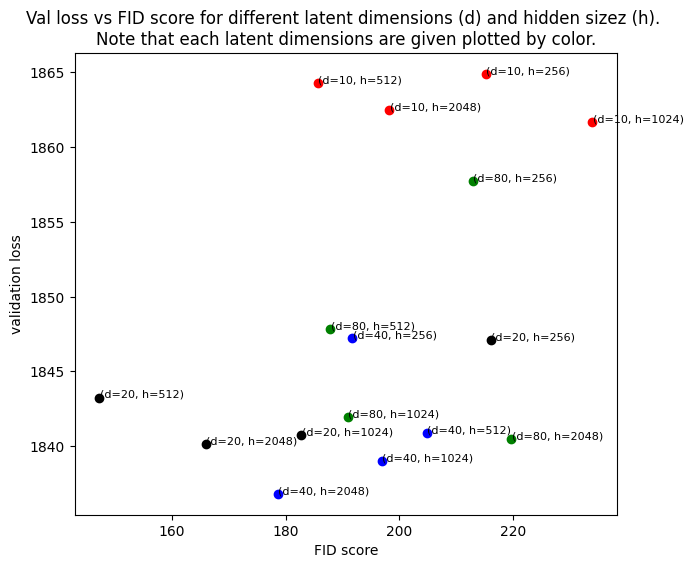

In [ ]:
py.figure(figsize=(7,6))

color_dic = {10 : 'red', 20 : 'black', 40 : 'blue', 80 : 'green'}

for d in [10,20,40,80]:
    for h in [256, 512, 1024, 2048]:
        fid = model_FID[(d,h)]
        param = model_param[(d,h)]
        val_loss = model_val_loss[(d,h)]

        py.scatter(fid, val_loss, color=color_dic[d])
        py.annotate(f"(d={d}, h={h})", (fid + .05, val_loss), fontsize=8)



        print('model with dim = {} and hidden = {}:\n FID score = {:.4f}, val loss = {:.4f}, num params = {}\n'.format(
              d,h,fid,val_loss, param))




py.title("Val loss vs FID score for different latent dimensions (d) and hidden sizez (h). \nNote that each latent dimensions are given plotted by color.")
py.xlabel('FID score')
py.ylabel('validation loss')
py.show()

In [ ]:
ten_models = []
ten_losses = []
Q1_vals = []
Q10_vals = []
Q100_vals = []


#here are the params for my favorite model
cifarpars.latent_dim= 40
cifarpars.hidden_dim= 2048

for i in range(10):
    trained_net_num, train_losses_num, _, _, val_losses_num = train_net(cifarpars, single_digit = i)
    ten_models.append(trained_net_num)


    Xtest_cifar = cXtest[cYtest == i]

    negQ1_val = -Q_k(trained_net_num, torch.torch.from_numpy(Xtest_cifar), k = 1).item()
    negQ10_val = -Q_k(trained_net_num, torch.torch.from_numpy(Xtest_cifar), k = 10).item()
    negQ100_val = -Q_k(trained_net_num, torch.torch.from_numpy(Xtest_cifar), k = 100).item()

    Q1_vals.append(negQ1_val)
    Q10_vals.append(negQ10_val)
    Q100_vals.append(negQ100_val)



Total parameters:  12835920
X_train size: (4800, 3072)
Y_train size: (4800,)
X_test size: (600, 3072)
Y_test size: (600,)
batch tensor size: (1000, 3072)
Training set epoch 0: Avg. loss: 2229.3257
Validation set: Avg. loss: 3506.0771

Training set epoch 1: Avg. loss: 2115.2861
Validation set: Avg. loss: 3468.7679

Training set epoch 2: Avg. loss: 2087.4310
Validation set: Avg. loss: 3416.8034

Training set epoch 3: Avg. loss: 2052.4986
Validation set: Avg. loss: 3358.8694

Training set epoch 4: Avg. loss: 2021.4075
Validation set: Avg. loss: 3333.4306

Training set epoch 5: Avg. loss: 1992.6936
Validation set: Avg. loss: 3278.9549

Training set epoch 6: Avg. loss: 1966.6961
Validation set: Avg. loss: 3254.6271

Training set epoch 7: Avg. loss: 1955.8195
Validation set: Avg. loss: 3237.3897

Training set epoch 8: Avg. loss: 1946.5999
Validation set: Avg. loss: 3221.6563

Training set epoch 9: Avg. loss: 1939.1552
Validation set: Avg. loss: 3214.5976

Training set epoch 10: Avg. loss: 19

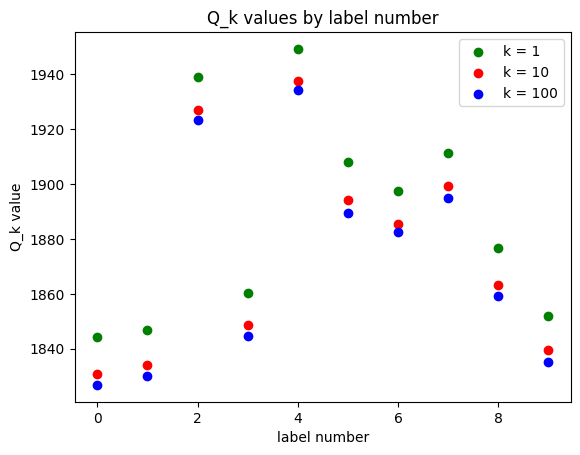

In [ ]:

nums = list(range(10))

py.scatter(nums, Q1_vals, color='green', label='k = 1')
py.scatter(nums, Q10_vals, color='red', label='k = 10')
py.scatter(nums, Q100_vals, color='blue', label='k = 100')


py.title("Q_k values by label number")
py.xlabel('label number')
py.ylabel('Q_k value')
py.legend()
py.show()

20 generated zero's:


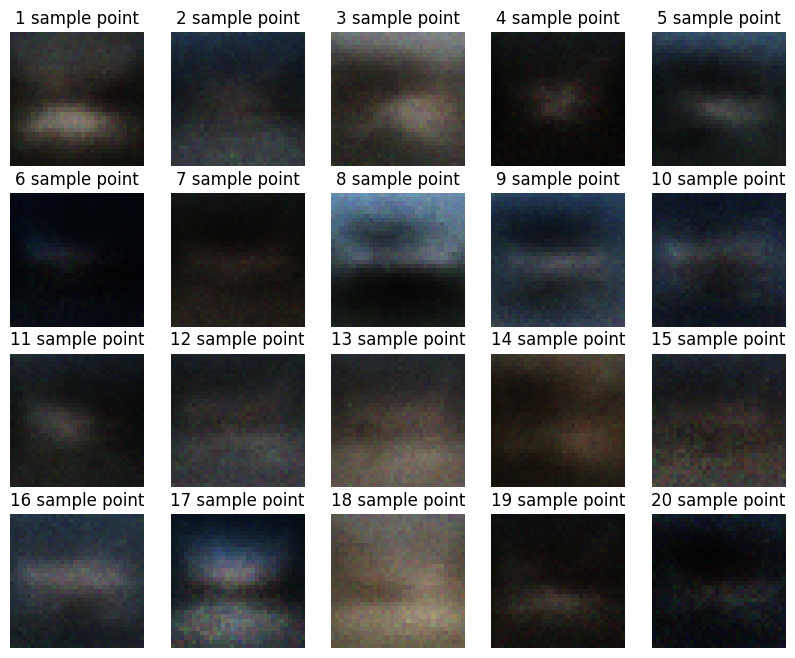

In [ ]:
zero_cifar_samples = gen_random_samples(ten_models[0], 20)

print("20 generated zero's:")
display_cifar(zero_cifar_samples)